## AIM: Train Graph Convulation Networks (GCNs) as multiclass classification models for predicting the psychiatric diagnosis based on EEG features

GraphLambda with & without edge attributes for predicting psychiatric diagnosis with statistical features of the power per frequency band per channel group (frontal, central, parietal, occipital) and connectivity features per frequency band per channel group (l/m/r; frontal, central, ). Statistical features are calculated with EC data, EO data and a with the ratio between EC divided by EO.

Have to use features before feature selection, to maintain even dimensions for each graph. Stat features are standardized before training. Models are tuned using multi-objective Optuna, maximizing val f1 and minimizing val loss

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import optuna

import lightning.pytorch as pl
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv, GATv2Conv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx, to_networkx
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

### Load data & features

In [2]:
import pickle
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

In [3]:
# import stat & conn features without feature selection
df_stat_conn_features = pd.read_pickle('df_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])

# label encode diagnosis
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_stat_conn_features['diagnosis'])
df_stat_conn_features['diagnosis'] = le.transform(df_stat_conn_features['diagnosis'])

print(df_stat_conn_features.shape)
df_stat_conn_features.sample(3)

(2700, 1218)


ID  diagnosis  epoch  EO_l_frontal_delta_std  \
223   sub-87968405          4      8                0.054586   
175   sub-87967869          4      8                0.151530   
1860  sub-88054173          0      1                0.076535   

      EO_l_frontal_delta_mean  EO_l_frontal_delta_median  \
223                  0.067259                   0.067259   
175                  0.086333                   0.086333   
1860                 0.107322                   0.107322   

      EO_l_frontal_delta_skew  EO_l_frontal_delta_kurt  \
223                  1.980829                 4.419257   
175                  5.328408                30.126662   
1860                 1.132573                 1.203088   

      EO_l_frontal_theta_std  EO_l_frontal_theta_mean  ...  \
223                 0.024427                 0.043785  ...   
175                 0.046424                 0.051189  ...   
1860                0.030544                 0.061180  ...   

      ratio_gamma_m_central-r_central  ratio_gamma_m_central-l_posterior  \
223                          0.855846                           0.812709   
175                          1.020114                           1.019488   
1860                         1.018516                           0.984305   

      ratio_gamma_m_central-m_posterior  ratio_gamma_m_central-r_posterior  \
223                            0.848298                           0.819834   
175                            1.007923                           1.008713   
1860                           1.010429                           0.996636   

      ratio_gamma_r_central-l_posterior  ratio_gamma_r_central-m_posterior  \
223                            0.761955                           0.805423   
175                            1.014391                           1.016999   
1860                           0.968132                           0.982883   

      ratio_gamma_r_central-r_posterior  ratio_gamma_l_posterior-m_posterior  \
223                            0.818245                             0.878715   
175                            1.002181                             1.006644   
1860                           0.980889                             0.994332   

      ratio_gamma_l_posterior-r_posterior  ratio_gamma_m_posterior-r_posterior  
223                              0.818443                             0.876020  
175                              1.012184                             0.999998  
1860                             0.951039                             0.976442  

[3 rows x 1218 columns]

In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 408)
(2700, 408)
(2700, 408)


In [5]:
synchrony_feature_dict = load_file('synchrony_feature_dict.pkl')
subjects_ec_syncro_matrices = synchrony_feature_dict['EC_syncro']
subjects_eo_syncro_matrices = synchrony_feature_dict['EO_syncro']
subjects_ec_ids = synchrony_feature_dict['EC_IDs']
subjects_eo_ids = synchrony_feature_dict['EO_IDs']
print(len(subjects_ec_syncro_matrices), len(subjects_eo_syncro_matrices))
print(len(subjects_ec_ids), len(subjects_eo_ids))
print(subjects_ec_syncro_matrices[0].shape)
print(subjects_ec_ids[0])

224 225
224 225
(12, 5, 9, 9)
sub-87964717


In [6]:
# compute ratio [EC/EO] synchrony matrices

# Convert the lists to sets
subjects_ec_ids_set = set(subjects_ec_ids)
subjects_eo_ids_set = set(subjects_eo_ids)

# find the missing IDs to make sure ratio is computed within the same participant
missing_ids = subjects_eo_ids_set - subjects_ec_ids_set
missing_ids_indices = [subjects_eo_ids.index(id) for id in missing_ids]

# remove missing IDs from EO
ratio_subjects_eo_syncro_matrices = [matrix for i, matrix in enumerate(subjects_eo_syncro_matrices) if i not in missing_ids_indices]
assert len(ratio_subjects_eo_syncro_matrices) == len(subjects_ec_syncro_matrices)

# compute ratio
subjects_ratio_syncro_matrices = []
for i in range(len(subjects_ec_syncro_matrices)):
    ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]
    subjects_ratio_syncro_matrices.append(ratio_matrix)
subjects_ratio_ids = subjects_ec_ids
print(len(subjects_ratio_syncro_matrices), len(subjects_ratio_ids))

224 224


/tmp/ipykernel_4107673/1473655494.py:18: RuntimeWarning: invalid value encountered in divide
  ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]


In [7]:
# define function to store features in PyTorch Geometric Data objects
import networkx as nx
from joblib import Parallel, delayed # for parallel processing
from tqdm import tqdm
def process_subject(syncros, subject_id, df_features):
    graph_dataset = []
    y_list = []

    # obtain statistical features for subject
    subject_stat_features = df_features[df_features['ID'] == subject_id]
    stat_columns = ['epoch', 'mean', 'median', 'std', 'kurt', 'skew'] # select statistical features
    pattern = '|'.join(stat_columns)  # create a pattern string
    subject_stat_features = subject_stat_features[subject_stat_features.columns[subject_stat_features.columns.str.contains(pattern)]]
    
    for epoch, syncro_matrices in enumerate(syncros):
        num_edges = int((syncro_matrices.shape[1] * (syncro_matrices.shape[2] - 1)) / 2)
        bands = syncro_matrices.shape[0]
        edge_attrs = np.zeros((num_edges, bands)) # create empty array to store edge weights for each frequency band

        for i, syncro_matrix in enumerate(syncro_matrices):
            # print(f'{syncro_matrix.shape = }')
            syncro_graph = nx.from_numpy_array(syncro_matrix)
            # print(f'{syncro_graph = }')
            edge_list = nx.to_pandas_edgelist(syncro_graph)
            edge_list = edge_list.dropna(axis=0)
            # print(f'{edge_list = }')
            edge_index = edge_list.iloc[:,0:2].values.T # shape (2, num_edges), edge_index stays the same for all bands right?
            # print(f'{edge_index = }')
            edge_attr = edge_list.iloc[:,2].values#.reshape(-1,1)
            edge_attrs[:,i] = edge_attr

        y = df_stat_conn_features_ec[df_stat_conn_features_ec['ID'] == subject_id]['diagnosis'].values[0]
        
        # store statistical features for subject
        ch_groups = ['l_frontal', 'm_frontal', 'r_frontal', 'l_central', 'm_central', 'r_central', 'l_posterior', 'm_posterior', 'r_posterior']
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        x = np.zeros((len(ch_groups), len(bands) * (len(stat_columns)-1))) # -1 because of epochs column in stat_columns
        # print(x.shape)
        for num, ch_group in enumerate(ch_groups):
            x[num] = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            

        data = Data(x=torch.tensor(x, dtype=torch.float),                     # Node features [num_nodes, num_node_features]
                    edge_index=torch.tensor(edge_index, dtype=torch.long),    # Adjacency matrix [2, num_edges]
                    edge_attr=torch.tensor(edge_attrs,dtype=torch.float),  # Edge features [num_edges, num_edge_features]
                    y=torch.tensor([y], dtype=torch.long))                    # Target/Label (it should be a list) --> torch.long for classification, torch.float for regression
        graph_dataset.append(data)
        y_list.append(y)

    return graph_dataset, y_list

In [8]:
# retrieve and store data for EC features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ec) for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids), total=len(subjects_ec_syncro_matrices)))

ec_graph_dataset = []
ec_y_list = []
for result in results:
    ec_graph_dataset.extend(result[0])
    ec_y_list.extend(result[1])
    
assert len(ec_graph_dataset) == len(ec_y_list)

print(f'{ec_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ec_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ec_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ec_graph_dataset) = }, subjects: {len(subjects_ec_syncro_matrices)}, epochs: {len(subjects_ec_syncro_matrices[0])}')
print(f'{ec_graph_dataset[0] = }')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:05<00:00, 37.78it/s]


ec_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ec_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ec_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ec_graph_dataset) = 2688, subjects: 224, epochs: 12
ec_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [9]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_eo) for syncros, subject_id in tqdm(zip(subjects_eo_syncro_matrices, subjects_eo_ids), total=len(subjects_eo_syncro_matrices)))

eo_graph_dataset = []
eo_y_list = []
for result in results:
    eo_graph_dataset.extend(result[0])
    eo_y_list.extend(result[1])
    
assert len(eo_graph_dataset) == len(eo_y_list)

print(f'{eo_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{eo_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{eo_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(eo_graph_dataset) = }, subjects: {len(subjects_eo_syncro_matrices)}, epochs: {len(subjects_eo_syncro_matrices[0])}')
print(f'{eo_graph_dataset[0] = }')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:02<00:00, 93.19it/s]


eo_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
eo_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
eo_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(eo_graph_dataset) = 2700, subjects: 225, epochs: 12
eo_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [10]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ratio) for syncros, subject_id in tqdm(zip(subjects_ratio_syncro_matrices, subjects_ratio_ids), total=len(subjects_ratio_syncro_matrices)))

# process_subject(subjects_ratio_syncro_matrices[0], subjects_ratio_ids[0])

ratio_graph_dataset = []
ratio_y_list = []
for result in results:
    ratio_graph_dataset.extend(result[0])
    ratio_y_list.extend(result[1])
    
assert len(ratio_graph_dataset) == len(ratio_y_list)

print(f'{ratio_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ratio_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ratio_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ratio_graph_dataset) = }, subjects: {len(subjects_ratio_syncro_matrices)}, epochs: {len(subjects_ratio_syncro_matrices[0])}')
print(f'{ratio_graph_dataset[0] = }')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:02<00:00, 87.28it/s]


ratio_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ratio_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ratio_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ratio_graph_dataset) = 2688, subjects: 224, epochs: 12
ratio_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


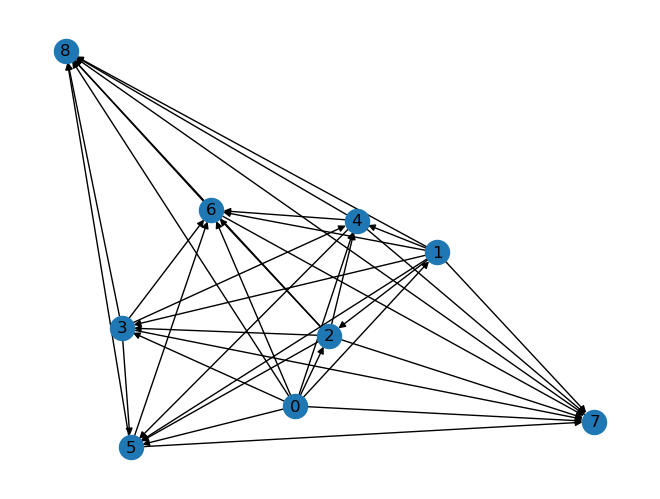

In [11]:
nx.draw(to_networkx(ratio_graph_dataset[0]), with_labels=True)

In [12]:
# load the indices of the validation sets from the ML models
data_split_indices = load_file('data_split_indices.pkl')

# GCN models:

### GCNConv with log_softmax activation function and NLLLoss

In [13]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from torch.nn import Dropout1d
import seaborn as sns
import matplotlib.pyplot as plt

n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
param = 64
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class GCN(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, dropout):
        super(GCN, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        self.conv1 = GCNConv(n_features, param, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(param)
        self.do1 = Dropout1d(p=dropout)
        self.conv2 = GCNConv(param, param, cached=False)
        self.bn2 = BatchNorm1d(param)
        self.do2 = Dropout1d(p=dropout)
        self.fc1 = Linear(param, param)
        self.bn3 = BatchNorm1d(param)
        self.do3 = Dropout1d(p=dropout)
        self.fc2 = Linear(param, 8)
        self.fc3 = Linear(8, num_classes)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='weighted')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='weighted')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.do1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = self.do2(x)
        x = global_add_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.do3(x)
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, p=0.2, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # Activation function for classification
        return x
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
            x, y = train_batch.x, train_batch.y
            output = self.forward(train_batch)
            loss = F.nll_loss(output, y)
            y_hat = output.argmax(dim=1)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True)
            self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
            return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss

    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        output = self.forward(batch)
        y_hat = output.argmax(dim=1)
        return y_hat


    # def backward(self, trainer, loss, optimizer, optimizer_idx):
    #     loss.backward()
    
    # def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx):
    #     optimizer.step()
    #     optimizer.zero_grad()

# 1. EC feature set

In [14]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EC'][0]
baseline_val_idxs = data_split_indices['EC'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ec_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ec_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ec_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ec_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ec_y_list[i] for i in baseline_rest_idxs]
Y_val = [ec_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ec_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


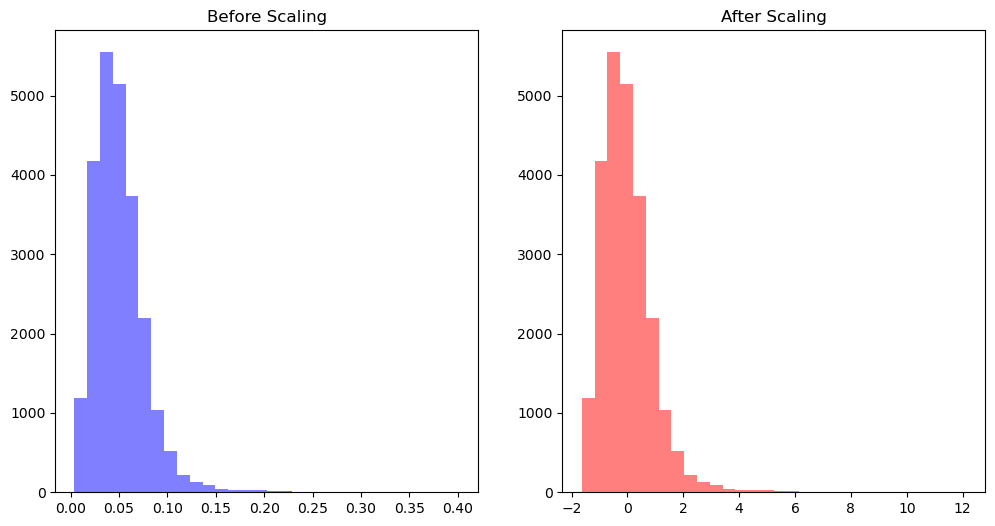

In [15]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: Standard GCN

In [16]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ec_results_stand_GCN_trials.pkl')

[I 2024-06-07 09:27:39,888] A new study created in memory with name: no-name-31ebdc91-bf00-417a-91fe-844c8d8b4897


Tested parameters: {'learning_rate': 0.0038353453873366103, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.5350505614538917}


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-06-07 09:30:56,091] Trial 0 finished with value: 0.27214622497558594 and parameters: {'learning_rate': 0.0038353453873366103, 'optimizer': 'Adam', '

Tested parameters: {'learning_rate': 0.07480707411849805, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.5238762106348044}


[I 2024-06-07 09:33:45,426] Trial 1 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.07480707411849805, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.5238762106348044}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.0006041280299665246, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.7134146726495345}


[I 2024-06-07 09:38:23,992] Trial 2 finished with value: 0.29024893045425415 and parameters: {'learning_rate': 0.0006041280299665246, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.7134146726495345}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.026400735071629534, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.3144593707690607}


[I 2024-06-07 09:41:38,413] Trial 3 finished with value: 0.2700885832309723 and parameters: {'learning_rate': 0.026400735071629534, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.3144593707690607}. Best is trial 1 with value: 0.3333333432674408.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.008420284086164069, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.056271910161521}


[I 2024-06-07 09:43:14,395] Trial 4 finished with value: 0.31258058547973633 and parameters: {'learning_rate': 0.008420284086164069, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.056271910161521}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.0001205156439589149, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.296706391917227}


[I 2024-06-07 09:43:21,494] Trial 5 pruned. Trial was pruned at epoch 100.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0035553488949497604, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.795920756124355}


[I 2024-06-07 09:45:39,624] Trial 6 finished with value: 0.29300379753112793 and parameters: {'learning_rate': 0.0035553488949497604, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.795920756124355}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.000901797344300438, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.01599708520346743}


[I 2024-06-07 09:47:11,040] Trial 7 finished with value: 0.3107264041900635 and parameters: {'learning_rate': 0.000901797344300438, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.01599708520346743}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.002058721497994572, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.30091833118776956}


[I 2024-06-07 09:49:27,285] Trial 8 finished with value: 0.2867891192436218 and parameters: {'learning_rate': 0.002058721497994572, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.30091833118776956}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.8338186126160792e-05, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.39340054371575955}


[I 2024-06-07 09:49:35,319] Trial 9 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.05187313048066866, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.5709970654854357}


[I 2024-06-07 09:52:29,082] Trial 10 finished with value: 0.29641351103782654 and parameters: {'learning_rate': 0.05187313048066866, 'optimizer': 'SGD', 'batch_size': 510, 'dropout': 0.5709970654854357}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.09900545303925926, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.0072006190796576885}


[I 2024-06-07 09:54:01,395] Trial 11 finished with value: 0.2974839210510254 and parameters: {'learning_rate': 0.09900545303925926, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.0072006190796576885}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.013634237749742453, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.14878407877438996}


[I 2024-06-07 09:55:31,719] Trial 12 finished with value: 0.30868178606033325 and parameters: {'learning_rate': 0.013634237749742453, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.14878407877438996}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.010898751438799138, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.5299997656561376}


[I 2024-06-07 09:58:23,795] Trial 13 finished with value: 0.30234211683273315 and parameters: {'learning_rate': 0.010898751438799138, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.5299997656561376}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.015556013598935565, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.20501283632824271}


[I 2024-06-07 09:58:31,488] Trial 14 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.08998539946627114, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6491221591040262}


[I 2024-06-07 10:00:05,705] Trial 15 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.08998539946627114, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6491221591040262}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.09939025004308863, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.6248431370823838}


[I 2024-06-07 10:02:55,567] Trial 16 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.09939025004308863, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.6248431370823838}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.00024370553054631525, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.450992614811743}


[I 2024-06-07 10:05:46,139] Trial 17 finished with value: 0.26220542192459106 and parameters: {'learning_rate': 0.00024370553054631525, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.450992614811743}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.043608318528496094, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6365394430023009}


[I 2024-06-07 10:07:20,734] Trial 18 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.043608318528496094, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6365394430023009}. Best is trial 1 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.1048784213882707e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.7315139065924252}


[I 2024-06-07 10:09:41,540] Trial 19 finished with value: 0.3641407787799835 and parameters: {'learning_rate': 1.1048784213882707e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.7315139065924252}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 1.3308985728279533e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.7965363307004354}


[I 2024-06-07 10:09:52,266] Trial 20 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 6.232465919410145e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6980632438444323}


[I 2024-06-07 10:12:13,031] Trial 21 finished with value: 0.31899169087409973 and parameters: {'learning_rate': 6.232465919410145e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.6980632438444323}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 2.9954546101512144e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.7011856247391994}


[I 2024-06-07 10:12:24,226] Trial 22 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0003259838069450537, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.45594522285285755}


[I 2024-06-07 10:17:03,312] Trial 23 finished with value: 0.2923780679702759 and parameters: {'learning_rate': 0.0003259838069450537, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.45594522285285755}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.03538781882477952, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6082931398503151}


[I 2024-06-07 10:18:36,733] Trial 24 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.03538781882477952, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6082931398503151}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.005163000814047342, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.7325732390910342}


[I 2024-06-07 10:18:48,073] Trial 25 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 9.89192369482089e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.4862966217901403}


[I 2024-06-07 10:21:33,883] Trial 26 finished with value: 0.2843688130378723 and parameters: {'learning_rate': 9.89192369482089e-05, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.4862966217901403}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.002081214259308446, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6559206669945286}


[I 2024-06-07 10:23:06,812] Trial 27 finished with value: 0.27029359340667725 and parameters: {'learning_rate': 0.002081214259308446, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6559206669945286}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.022465361827175453, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5627179968573384}


[I 2024-06-07 10:25:27,886] Trial 28 finished with value: 0.29933738708496094 and parameters: {'learning_rate': 0.022465361827175453, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.5627179968573384}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.05993131350135358, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.5171005558599483}


[I 2024-06-07 10:28:39,980] Trial 29 finished with value: 0.2866749167442322 and parameters: {'learning_rate': 0.05993131350135358, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.5171005558599483}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.006505103630170757, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.7528961263757408}


[I 2024-06-07 10:31:26,823] Trial 30 finished with value: 0.2952239513397217 and parameters: {'learning_rate': 0.006505103630170757, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.7528961263757408}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.09259410565888308, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.6158243327902235}


[I 2024-06-07 10:34:16,365] Trial 31 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.09259410565888308, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.6158243327902235}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.095636460139261, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.6654103597512222}


[I 2024-06-07 10:37:04,366] Trial 32 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.095636460139261, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.6654103597512222}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.025216059025145697, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.5859856502913967}


[I 2024-06-07 10:39:52,596] Trial 33 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.025216059025145697, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.5859856502913967}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.05460023008004204, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.6590696133002779}


[I 2024-06-07 10:44:26,851] Trial 34 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.05460023008004204, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.6590696133002779}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.019079558379494866, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.4096069161695718}


[I 2024-06-07 10:47:44,355] Trial 35 finished with value: 0.30539682507514954 and parameters: {'learning_rate': 0.019079558379494866, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.4096069161695718}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.00045366385182591177, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.7481985236479338}


[I 2024-06-07 10:50:34,017] Trial 36 finished with value: 0.2849615514278412 and parameters: {'learning_rate': 0.00045366385182591177, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.7481985236479338}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.0017352221898222395, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6893191832098595}


[I 2024-06-07 10:53:48,940] Trial 37 finished with value: 0.30347877740859985 and parameters: {'learning_rate': 0.0017352221898222395, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6893191832098595}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.030066559106139163, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.5436346758729883}


[I 2024-06-07 10:55:21,837] Trial 38 finished with value: 0.2850223481655121 and parameters: {'learning_rate': 0.030066559106139163, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.5436346758729883}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 4.7930732723383375e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6159153824450916}


[I 2024-06-07 10:57:41,119] Trial 39 finished with value: 0.30954480171203613 and parameters: {'learning_rate': 4.7930732723383375e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.6159153824450916}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.00019225173734331962, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.36266674549004657}


[I 2024-06-07 11:00:30,829] Trial 40 finished with value: 0.25470054149627686 and parameters: {'learning_rate': 0.00019225173734331962, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.36266674549004657}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.04526259156197175, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6454282841993703}


[I 2024-06-07 11:02:03,922] Trial 41 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.04526259156197175, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6454282841993703}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.06775103277332124, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.7667360818718392}


[I 2024-06-07 11:03:37,209] Trial 42 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.06775103277332124, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.7667360818718392}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.031055961195092786, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5081281577524591}


[I 2024-06-07 11:05:08,764] Trial 43 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.031055961195092786, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5081281577524591}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.009071362993684624, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5820551831527498}


[I 2024-06-07 11:06:38,439] Trial 44 finished with value: 0.308083176612854 and parameters: {'learning_rate': 0.009071362993684624, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5820551831527498}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.043894994599035626, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.6298667128617204}


[I 2024-06-07 11:08:12,880] Trial 45 finished with value: 0.2910464107990265 and parameters: {'learning_rate': 0.043894994599035626, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.6298667128617204}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.0009436691134164139, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.7247254048287068}


[I 2024-06-07 11:08:20,813] Trial 46 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.07157897754556744, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.6758425456449523}


[I 2024-06-07 11:11:08,453] Trial 47 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.07157897754556744, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.6758425456449523}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.014880137930272635, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.48246632694189756}


[I 2024-06-07 11:12:39,832] Trial 48 finished with value: 0.3106100857257843 and parameters: {'learning_rate': 0.014880137930272635, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.48246632694189756}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.0030739647328680165, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5560513085837069}


[I 2024-06-07 11:14:57,751] Trial 49 finished with value: 0.2916615605354309 and parameters: {'learning_rate': 0.0030739647328680165, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.5560513085837069}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.09938037254928764, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.2289972933271082}


[I 2024-06-07 11:17:41,932] Trial 50 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.09938037254928764, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.2289972933271082}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.03616111601837977, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5949835759562876}


[I 2024-06-07 11:19:13,716] Trial 51 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.03616111601837977, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5949835759562876}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.03945494917308217, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6251161745952954}


[I 2024-06-07 11:20:46,310] Trial 52 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.03945494917308217, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6251161745952954}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.06829984666359501, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6998816598207677}


[I 2024-06-07 11:22:20,117] Trial 53 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.06829984666359501, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6998816598207677}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.01942190753397366, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.7685549281185827}


[I 2024-06-07 11:23:53,891] Trial 54 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.01942190753397366, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.7685549281185827}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.049930331578558564, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.612393494552297}


[I 2024-06-07 11:26:11,921] Trial 55 finished with value: 0.31042200326919556 and parameters: {'learning_rate': 0.049930331578558564, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.612393494552297}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 1.067887866828636e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.09489116601786912}


[I 2024-06-07 11:26:26,073] Trial 56 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.03174339451127532, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5395369822815053}


[I 2024-06-07 11:29:41,050] Trial 57 finished with value: 0.35917016863822937 and parameters: {'learning_rate': 0.03174339451127532, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5395369822815053}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.010630165209199035, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.41001101461768974}


[I 2024-06-07 11:33:04,901] Trial 58 finished with value: 0.31655657291412354 and parameters: {'learning_rate': 0.010630165209199035, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.41001101461768974}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.0006911210651047249, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.4515931025252733}


[I 2024-06-07 11:36:20,670] Trial 59 finished with value: 0.29807883501052856 and parameters: {'learning_rate': 0.0006911210651047249, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.4515931025252733}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.07324646408052228, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.542675046662403}


[I 2024-06-07 11:39:38,839] Trial 60 finished with value: 0.3019264340400696 and parameters: {'learning_rate': 0.07324646408052228, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.542675046662403}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.027427493882349684, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7190935197355304}


[I 2024-06-07 11:42:54,847] Trial 61 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.027427493882349684, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7190935197355304}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.037151373676157576, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.5896831645994257}


[I 2024-06-07 11:45:44,755] Trial 62 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.037151373676157576, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.5896831645994257}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 2.4701914659394407e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.498263032128087}


[I 2024-06-07 11:45:55,718] Trial 63 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00661540709892388, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.6432308268047513}


[I 2024-06-07 11:50:30,884] Trial 64 finished with value: 0.2924272418022156 and parameters: {'learning_rate': 0.00661540709892388, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.6432308268047513}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.08018194874021935, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.6836610144932596}


[I 2024-06-07 11:53:21,767] Trial 65 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.08018194874021935, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.6836610144932596}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.052767089738183254, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.5302907846523859}


[I 2024-06-07 11:54:51,997] Trial 66 finished with value: 0.2942503094673157 and parameters: {'learning_rate': 0.052767089738183254, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.5302907846523859}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.018772147434616353, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5682533367125835}


[I 2024-06-07 11:58:00,210] Trial 67 finished with value: 0.2716471254825592 and parameters: {'learning_rate': 0.018772147434616353, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5682533367125835}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.01276013721905158, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6011758964436366}


[I 2024-06-07 12:00:17,029] Trial 68 finished with value: 0.28631386160850525 and parameters: {'learning_rate': 0.01276013721905158, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.6011758964436366}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.05902607372646308, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.6642291016258735}


[I 2024-06-07 12:03:05,078] Trial 69 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.05902607372646308, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.6642291016258735}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.0245232566979982, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6351661811125824}


[I 2024-06-07 12:04:39,084] Trial 70 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.0245232566979982, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6351661811125824}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.09585446923604049, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.6135657210240846}


[I 2024-06-07 12:07:33,665] Trial 71 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.09585446923604049, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.6135657210240846}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.07747147317811949, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.5534348354677947}


[I 2024-06-07 12:10:21,345] Trial 72 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.07747147317811949, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.5534348354677947}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.03501169969548633, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.7881457265432663}


[I 2024-06-07 12:13:08,742] Trial 73 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.03501169969548633, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.7881457265432663}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.046994288872805275, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.737927082400357}


[I 2024-06-07 12:15:56,819] Trial 74 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.046994288872805275, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.737927082400357}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.09493715873320595, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.48109169642992583}


[I 2024-06-07 12:18:44,053] Trial 75 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.09493715873320595, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.48109169642992583}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.057673223923367614, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.701610220418404}


[I 2024-06-07 12:23:21,816] Trial 76 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.057673223923367614, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.701610220418404}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 6.735929469760032e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.649174754270151}


[I 2024-06-07 12:23:37,059] Trial 77 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.027976203573901962, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.5168230550126387}


[I 2024-06-07 12:26:48,544] Trial 78 finished with value: 0.2879910469055176 and parameters: {'learning_rate': 0.027976203573901962, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.5168230550126387}. Best is trial 19 with value: 0.3641407787799835.


Tested parameters: {'learning_rate': 0.00017417283315718926, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.5735497677050237}


[I 2024-06-07 12:29:07,888] Trial 79 finished with value: 0.3928565979003906 and parameters: {'learning_rate': 0.00017417283315718926, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.5735497677050237}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 0.00015455593635697748, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.5688273805662307}


[I 2024-06-07 12:29:18,017] Trial 80 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 9.274923444095313e-05, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.5832770462771785}


[I 2024-06-07 12:29:28,509] Trial 81 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0003648612617366143, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.6685633860553534}


[I 2024-06-07 12:29:38,325] Trial 82 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.07670487387979905, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.6079430700277985}


[I 2024-06-07 12:31:53,127] Trial 83 finished with value: 0.2851778566837311 and parameters: {'learning_rate': 0.07670487387979905, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.6079430700277985}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 1.6245862234878546e-05, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.6299122224766466}


[I 2024-06-07 12:32:00,967] Trial 84 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0027704694283967254, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.42725400467301333}


[I 2024-06-07 12:33:32,441] Trial 85 finished with value: 0.2872147858142853 and parameters: {'learning_rate': 0.0027704694283967254, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.42725400467301333}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 0.0012049434092547804, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5308505652732001}


[I 2024-06-07 12:35:53,198] Trial 86 finished with value: 0.2968762516975403 and parameters: {'learning_rate': 0.0012049434092547804, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.5308505652732001}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 3.090483364152217e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.681318132231883}


[I 2024-06-07 12:37:25,541] Trial 87 finished with value: 0.38401100039482117 and parameters: {'learning_rate': 3.090483364152217e-05, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.681318132231883}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 4.2796178444619e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.343703824457114}


[I 2024-06-07 12:38:56,797] Trial 88 finished with value: 0.28525668382644653 and parameters: {'learning_rate': 4.2796178444619e-05, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.343703824457114}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 2.5234911088113068e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.4675666589887076}


[I 2024-06-07 12:39:10,723] Trial 89 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.083874407696298e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7146703423323322}


[I 2024-06-07 12:40:40,766] Trial 90 finished with value: 0.32077425718307495 and parameters: {'learning_rate': 1.083874407696298e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.7146703423323322}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 4.103629925424643e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6783695366403278}


[I 2024-06-07 12:40:55,101] Trial 91 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.7389375334353782e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6566969102144904}


[I 2024-06-07 12:41:08,620] Trial 92 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 3.13015743596747e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.5979436240693713}


[I 2024-06-07 12:41:17,581] Trial 93 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.06226835029671087, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.624486202741504}


[I 2024-06-07 12:44:32,147] Trial 94 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.06226835029671087, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.624486202741504}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 0.0002368329985377096, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6917791961547202}


[I 2024-06-07 12:46:53,298] Trial 95 finished with value: 0.3022889196872711 and parameters: {'learning_rate': 0.0002368329985377096, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.6917791961547202}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 0.042816861251970234, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.5762264342855613}


[I 2024-06-07 12:48:28,058] Trial 96 finished with value: 0.3042759895324707 and parameters: {'learning_rate': 0.042816861251970234, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.5762264342855613}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 0.08433636778489106, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.7584459770782982}


[I 2024-06-07 12:51:17,271] Trial 97 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.08433636778489106, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.7584459770782982}. Best is trial 79 with value: 0.3928565979003906.


Tested parameters: {'learning_rate': 1.3604464866209824e-05, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.7357312336541157}


[I 2024-06-07 12:51:25,290] Trial 98 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.032048827370993495, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5581261639426099}


[I 2024-06-07 12:52:59,676] Trial 99 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.032048827370993495, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5581261639426099}. Best is trial 79 with value: 0.3928565979003906.


Best trial:
  Value: 0.3928565979003906
  Params: 
    learning_rate: 0.00017417283315718926
    optimizer: SGD
    batch_size: 340
    dropout: 0.5735497677050237


In [17]:
df_trials = pd.read_pickle('ec_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
79      79  0.392857 2024-06-07 12:26:48.545208 2024-06-07 12:29:07.886934   
87      87  0.384011 2024-06-07 12:35:53.199383 2024-06-07 12:37:25.539905   
19      19  0.364141 2024-06-07 10:07:20.736797 2024-06-07 10:09:41.538453   
57      57  0.359170 2024-06-07 11:26:26.073998 2024-06-07 11:29:41.048620   
15      15  0.333333 2024-06-07 09:58:31.489571 2024-06-07 10:00:05.703446   
97      97  0.333333 2024-06-07 12:48:28.060516 2024-06-07 12:51:17.269939   
99      99  0.333333 2024-06-07 12:51:25.291834 2024-06-07 12:52:59.674971   
75      75  0.333333 2024-06-07 12:15:56.820639 2024-06-07 12:18:44.051243   
76      76  0.333333 2024-06-07 12:18:44.054669 2024-06-07 12:23:21.813597   
69      69  0.333333 2024-06-07 12:00:17.031123 2024-06-07 12:03:05.076957   

                 duration  params_batch_size  params_dropout  \
79 0 days 00:02:19.341726                340        0.573550   
87 0 days 00:01:32.340522                170        0.681318   
19 0 days 00:02:20.801656                340        0.731514   
57 0 days 00:03:14.974622                680        0.539537   
15 0 days 00:01:34.213875                170        0.649122   
97 0 days 00:02:49.209423                510        0.758446   
99 0 days 00:01:34.383137                170        0.558126   
75 0 days 00:02:47.230604                510        0.481092   
76 0 days 00:04:37.758928                850        0.701610   
69 0 days 00:02:48.045834                510        0.664229   

    params_learning_rate params_optimizer     state  
79              0.000174              SGD  COMPLETE  
87              0.000031          RMSprop  COMPLETE  
19              0.000011          RMSprop  COMPLETE  
57              0.031743          RMSprop  COMPLETE  
15              0.089985          RMSprop  COMPLETE  
97              0.084336          RMSprop  COMPLETE  
99              0.032049          RMSprop  COMPLETE  
75              0.094937          RMSprop  COMPLETE  
76              0.057673          RMSprop  COMPLETE  
69              0.059026          RMSprop  COMPLETE

#### Visualizations

In [18]:
# function to change axes size
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

/tmp/ipykernel_4107673/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

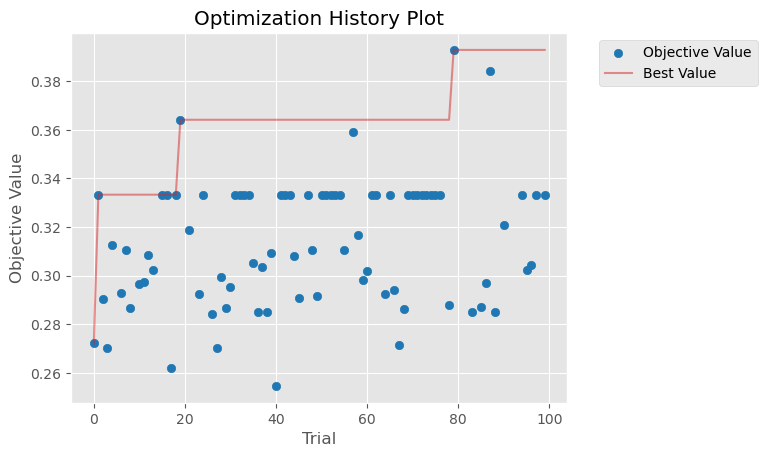

In [19]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-06-07 12:53:00,089] A new study created in memory with name: no-name-78b9409e-b460-4a1a-b232-f8e2920b7c4c
/tmp/ipykernel_4107673/3414932042.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


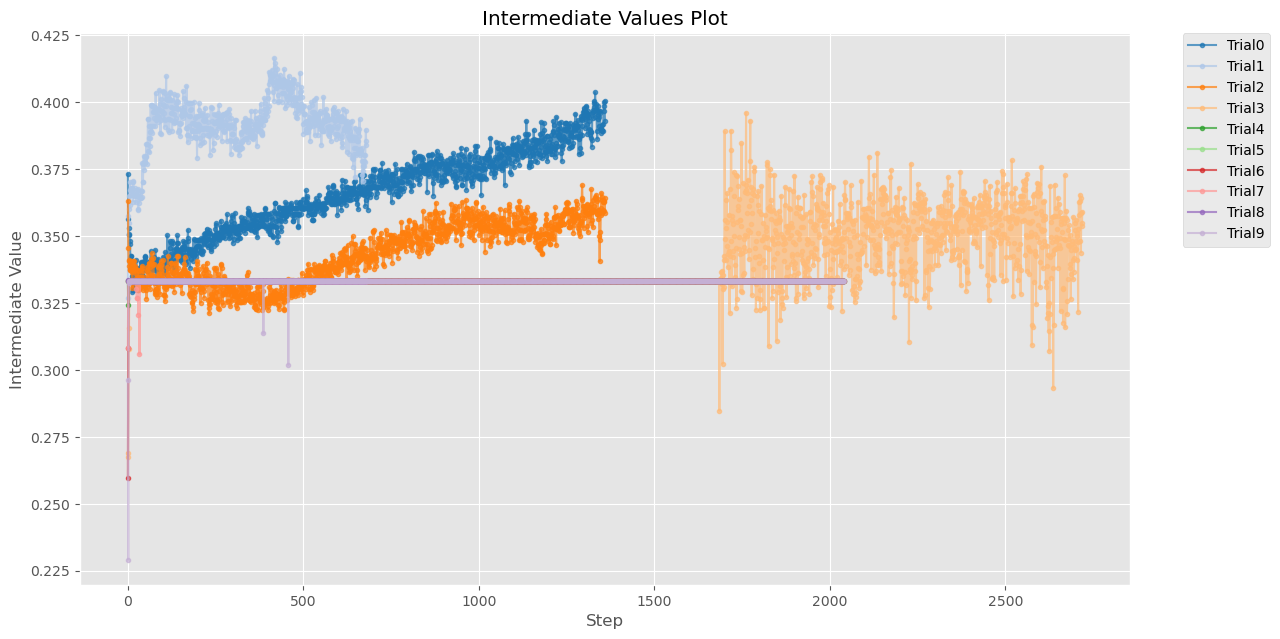

In [20]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_4107673/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


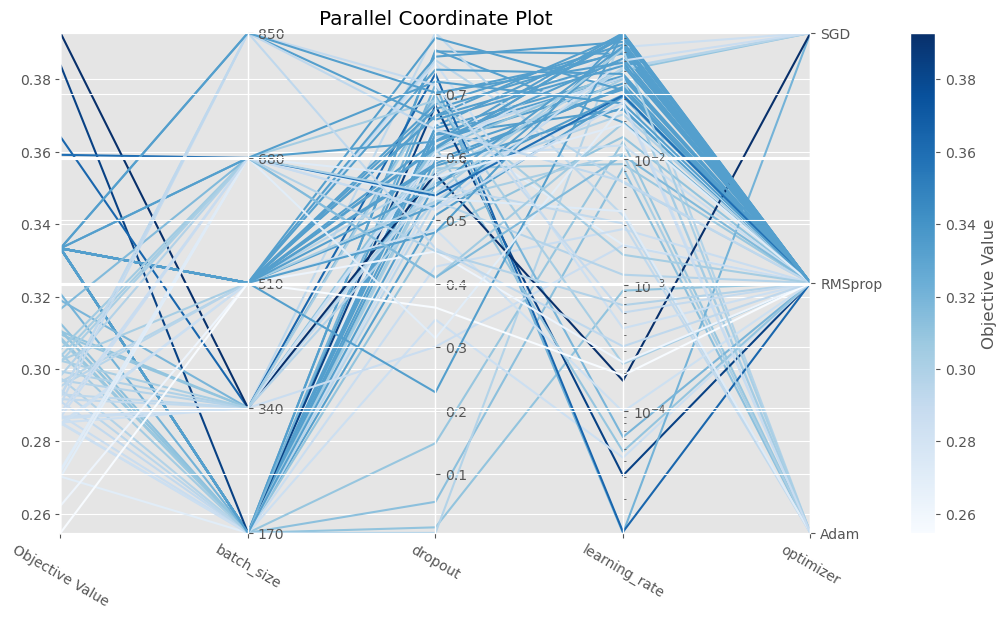

In [21]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_4107673/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-06-07 12:53:01,199] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


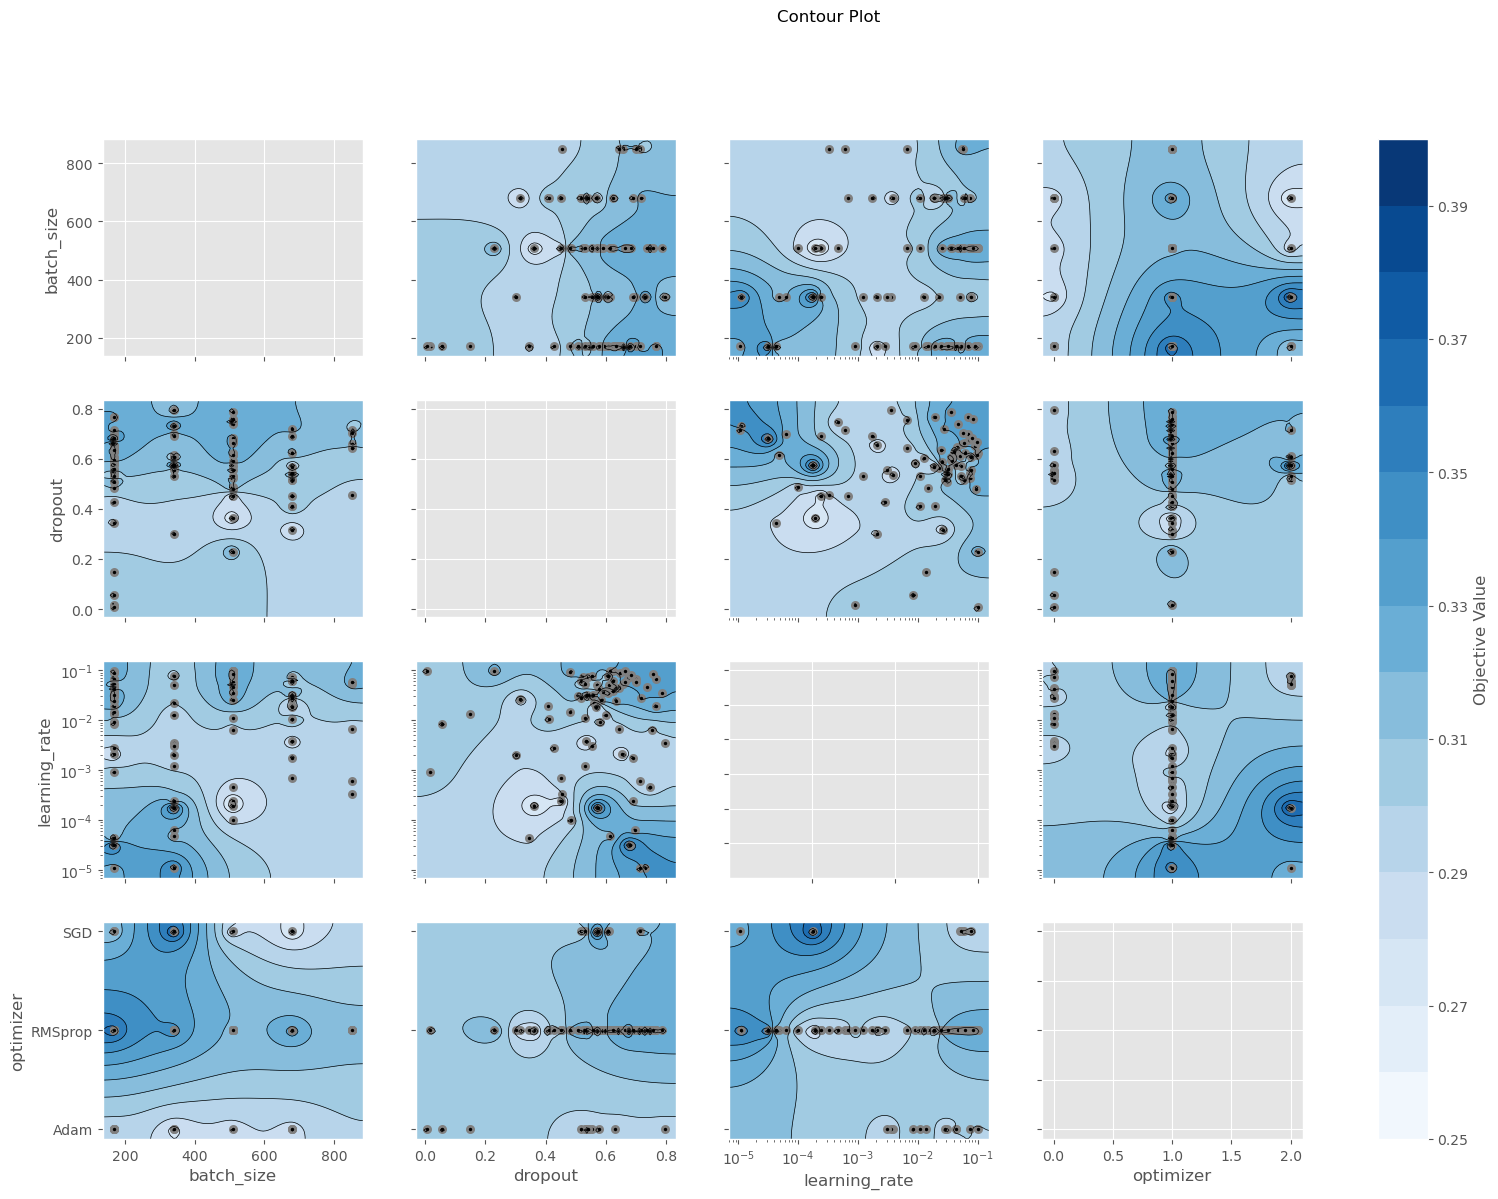

In [22]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_4107673/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

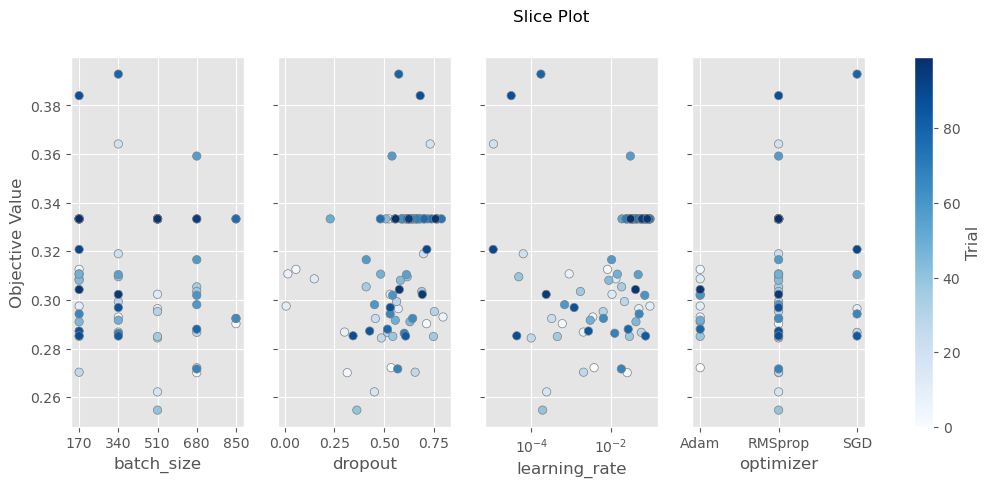

In [23]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_4107673/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

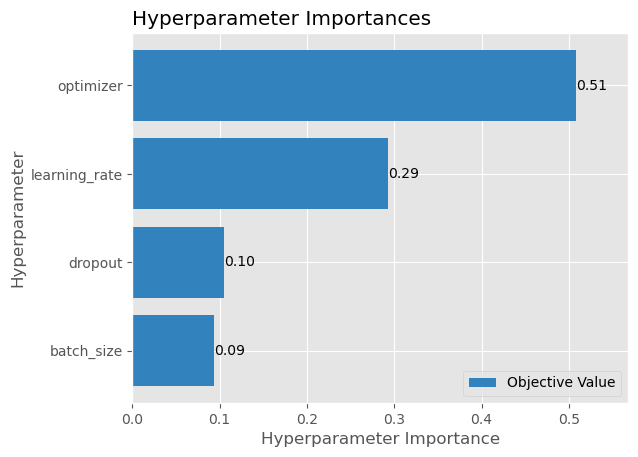

In [24]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_4107673/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

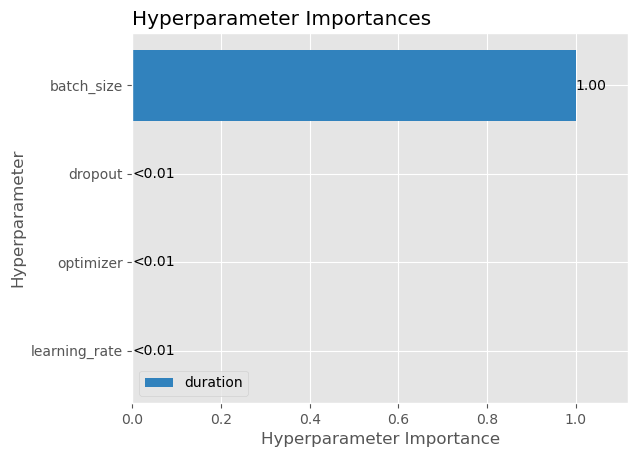

In [25]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_4107673/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

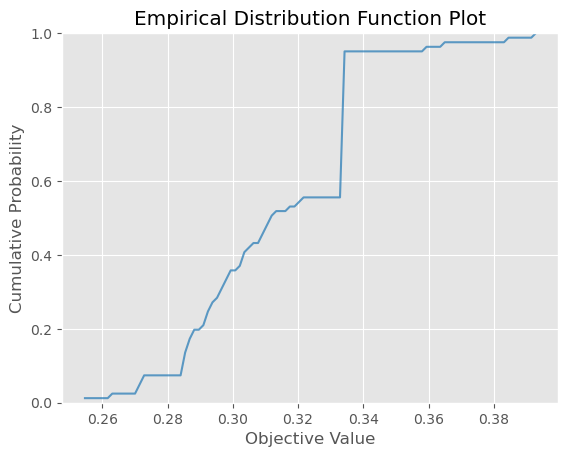

In [26]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_4107673/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-06-07 12:53:07,178] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


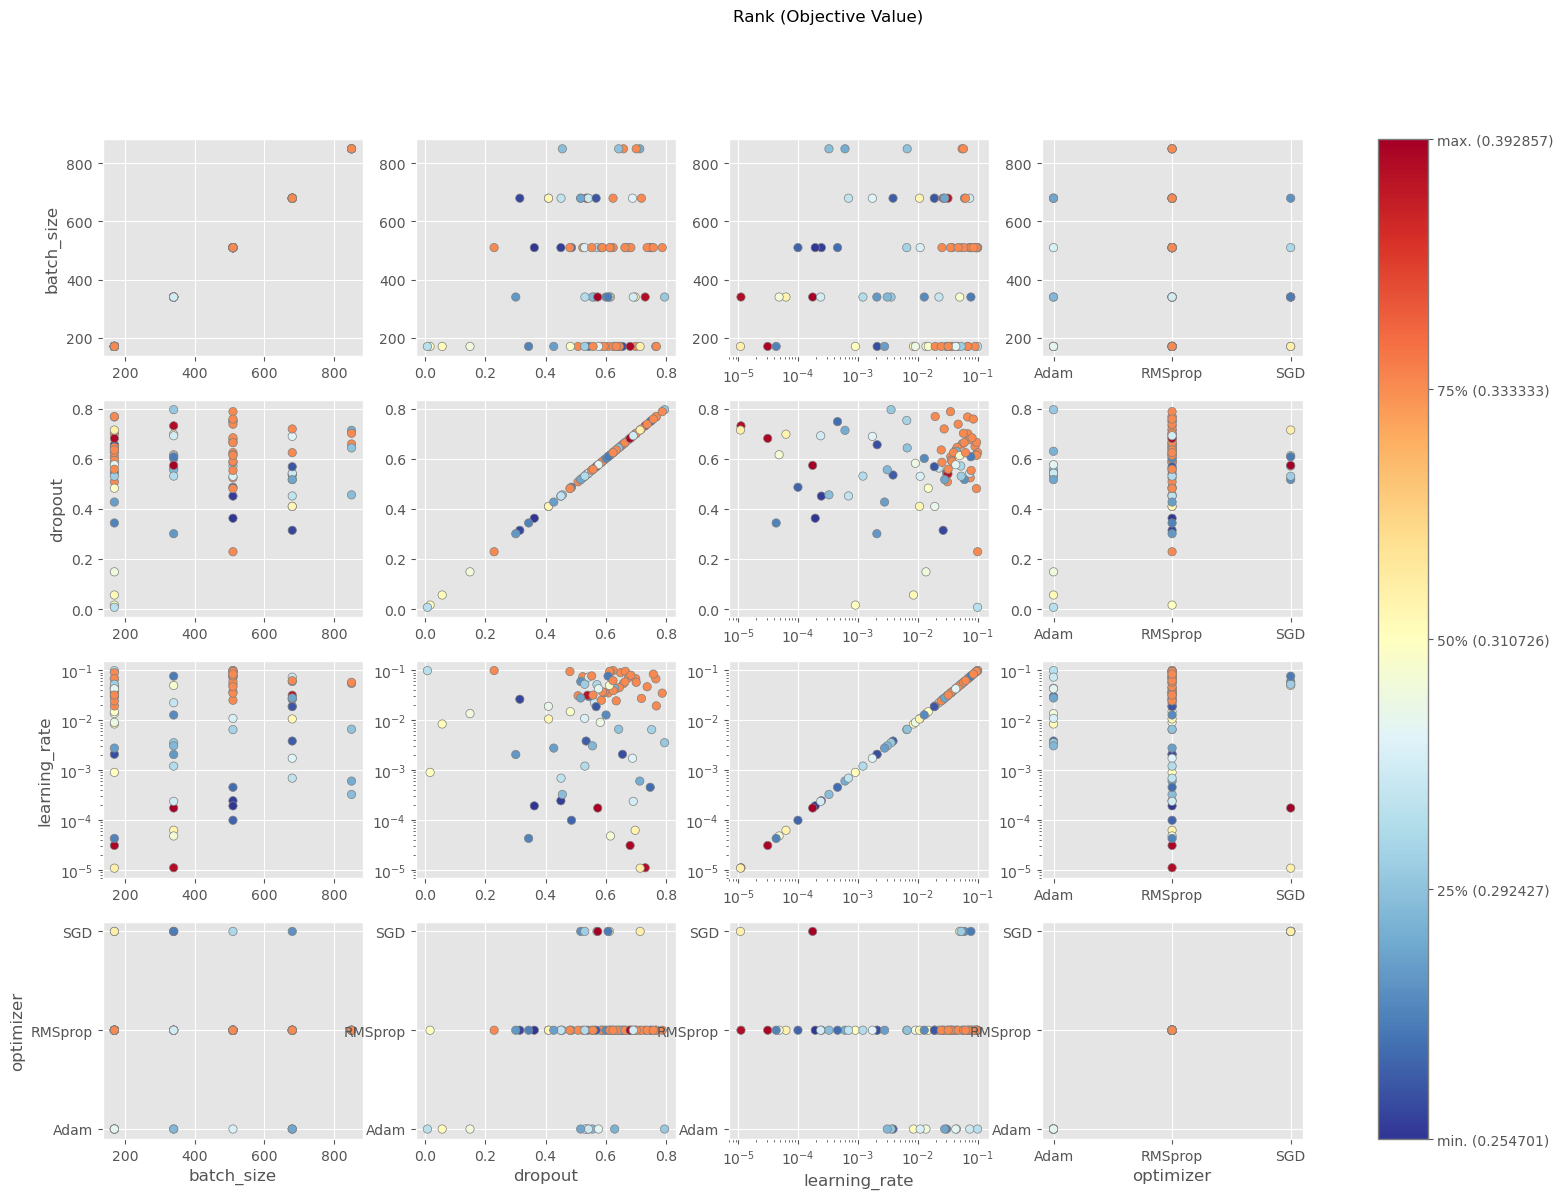

In [27]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_4107673/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


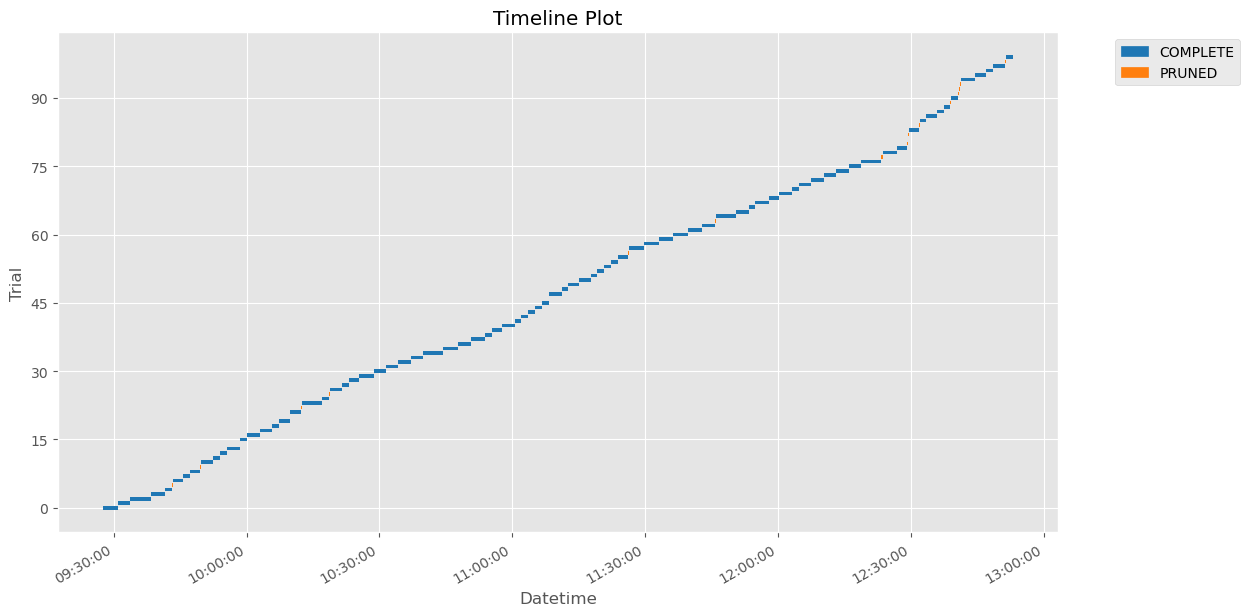

In [28]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

# 2. EO feature set

In [29]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EO'][0]
baseline_val_idxs = data_split_indices['EO'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_eo_ids for i in range(12)] # times 12 for each epoch

print(f'{len(eo_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [eo_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [eo_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[eo_y_list[i] for i in baseline_rest_idxs]
Y_val = [eo_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(eo_graph_dataset) = 2700
len(baseline_rest_idxs) = 2160, len(baseline_val_idxs) = 540, total: 2700
len(X_traintest) = 2160, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 444, total: 2160


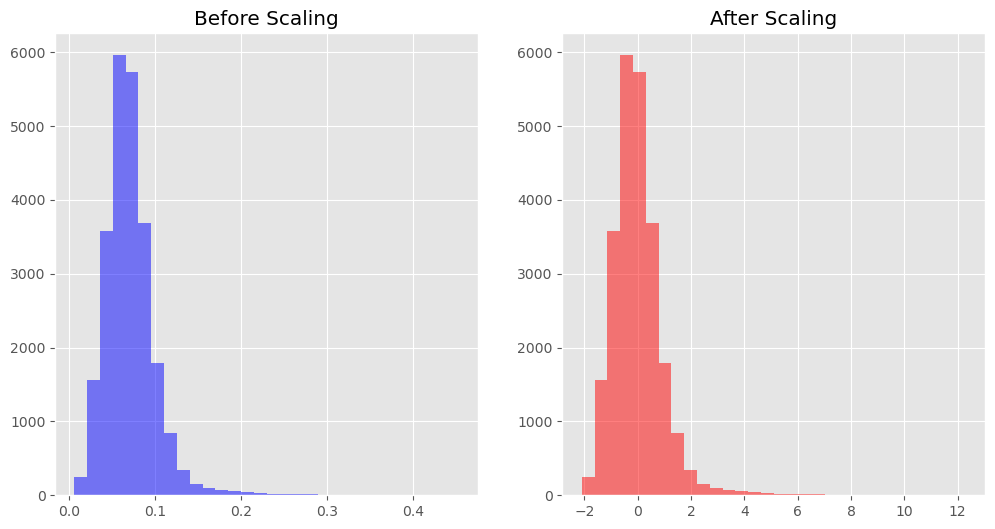

In [30]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: standard GCN

In [31]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('eo_results_stand_GCN_trials.pkl')

[I 2024-06-07 12:53:10,998] A new study created in memory with name: no-name-53f0be9e-e7db-4678-a2ab-ee189d423d8a
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.015095270718926107, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.3957512885627276}


[I 2024-06-07 12:55:28,853] Trial 0 finished with value: 0.2907116413116455 and parameters: {'learning_rate': 0.015095270718926107, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.3957512885627276}. Best is trial 0 with value: 0.2907116413116455.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 6.71896123199623e-05, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.2048471350115194}


[I 2024-06-07 12:58:19,547] Trial 1 finished with value: 0.30162733793258667 and parameters: {'learning_rate': 6.71896123199623e-05, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.2048471350115194}. Best is trial 1 with value: 0.30162733793258667.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0010966702476442904, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.6873945254086964}


[I 2024-06-07 13:02:54,521] Trial 2 finished with value: 0.28052234649658203 and parameters: {'learning_rate': 0.0010966702476442904, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.6873945254086964}. Best is trial 1 with value: 0.30162733793258667.


Tested parameters: {'learning_rate': 0.0029122838267486824, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.5986408122089587}


[I 2024-06-07 13:07:35,536] Trial 3 finished with value: 0.3436473309993744 and parameters: {'learning_rate': 0.0029122838267486824, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.5986408122089587}. Best is trial 3 with value: 0.3436473309993744.


Tested parameters: {'learning_rate': 0.04151953558527887, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.06335667814968948}


[I 2024-06-07 13:09:50,895] Trial 4 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.04151953558527887, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.06335667814968948}. Best is trial 3 with value: 0.3436473309993744.


Tested parameters: {'learning_rate': 0.023344330529610637, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.705338627319248}


[I 2024-06-07 13:12:12,166] Trial 5 finished with value: 0.3162091374397278 and parameters: {'learning_rate': 0.023344330529610637, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.705338627319248}. Best is trial 3 with value: 0.3436473309993744.


Tested parameters: {'learning_rate': 0.07757672973793714, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.4493984965210803}


[I 2024-06-07 13:15:25,635] Trial 6 finished with value: 0.2704552412033081 and parameters: {'learning_rate': 0.07757672973793714, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.4493984965210803}. Best is trial 3 with value: 0.3436473309993744.


Tested parameters: {'learning_rate': 0.003741108268646463, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.0996773218828036}


[I 2024-06-07 13:18:18,693] Trial 7 finished with value: 0.3161776065826416 and parameters: {'learning_rate': 0.003741108268646463, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.0996773218828036}. Best is trial 3 with value: 0.3436473309993744.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.000509869830022744, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.06206588264609314}


[I 2024-06-07 13:18:32,392] Trial 8 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 5.530019367885593e-05, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.3640982771281926}


[I 2024-06-07 13:21:26,834] Trial 9 finished with value: 0.2629242241382599 and parameters: {'learning_rate': 5.530019367885593e-05, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.3640982771281926}. Best is trial 3 with value: 0.3436473309993744.


Tested parameters: {'learning_rate': 0.0003562319994498297, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.5641195237943759}


[I 2024-06-07 13:21:34,513] Trial 10 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.004464738077657364, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5578826456477146}


[I 2024-06-07 13:23:51,375] Trial 11 finished with value: 0.2885487675666809 and parameters: {'learning_rate': 0.004464738077657364, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.5578826456477146}. Best is trial 3 with value: 0.3436473309993744.


Tested parameters: {'learning_rate': 0.09468352579812868, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.23345149317673297}


[I 2024-06-07 13:28:28,320] Trial 12 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.09468352579812868, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.23345149317673297}. Best is trial 3 with value: 0.3436473309993744.


Tested parameters: {'learning_rate': 1.0967989129497577e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7922744268072117}


[I 2024-06-07 13:31:41,460] Trial 13 finished with value: 0.40761128067970276 and parameters: {'learning_rate': 1.0967989129497577e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7922744268072117}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 1.7199350904048527e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7589957682772845}


[I 2024-06-07 13:31:48,386] Trial 14 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0001440053774643294, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.6043982662091936}


[I 2024-06-07 13:31:55,354] Trial 15 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0024454723170242365, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.7793377655832203}


[I 2024-06-07 13:33:26,402] Trial 16 finished with value: 0.3008732795715332 and parameters: {'learning_rate': 0.0024454723170242365, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.7793377655832203}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 1.2526797784683269e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6637965342971155}


[I 2024-06-07 13:36:38,331] Trial 17 finished with value: 0.305782675743103 and parameters: {'learning_rate': 1.2526797784683269e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6637965342971155}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.0013649468679145529, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.47798512415323935}


[I 2024-06-07 13:37:11,342] Trial 18 pruned. Trial was pruned at epoch 419.


Tested parameters: {'learning_rate': 0.012112582303490238, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.6240389635911107}


[I 2024-06-07 13:40:27,651] Trial 19 finished with value: 0.2984113395214081 and parameters: {'learning_rate': 0.012112582303490238, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.6240389635911107}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.00025122945437663463, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.7865768417495785}


[I 2024-06-07 13:45:04,313] Trial 20 finished with value: 0.2753504514694214 and parameters: {'learning_rate': 0.00025122945437663463, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.7865768417495785}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.029466693469688974, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.28806240324780674}


[I 2024-06-07 13:47:26,313] Trial 21 finished with value: 0.29466021060943604 and parameters: {'learning_rate': 0.029466693469688974, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.28806240324780674}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.007721510807529598, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.000833820839636637}


[I 2024-06-07 13:49:49,806] Trial 22 finished with value: 0.2689186632633209 and parameters: {'learning_rate': 0.007721510807529598, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.000833820839636637}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 3.204086672777837e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5180570345934316}


[I 2024-06-07 13:51:21,797] Trial 23 finished with value: 0.3220064640045166 and parameters: {'learning_rate': 3.204086672777837e-05, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5180570345934316}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.04773591927096699, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.3263684202642106}


[I 2024-06-07 13:54:41,112] Trial 24 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.04773591927096699, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.3263684202642106}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.00011988538059854818, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.7269908403120091}


[I 2024-06-07 13:59:24,984] Trial 25 finished with value: 0.3084561228752136 and parameters: {'learning_rate': 0.00011988538059854818, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.7269908403120091}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.0007306379294231203, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.15565438866419073}


[I 2024-06-07 14:01:45,919] Trial 26 finished with value: 0.2798621356487274 and parameters: {'learning_rate': 0.0007306379294231203, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.15565438866419073}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.0015816832187429872, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.43640867060017036}


[I 2024-06-07 14:04:08,657] Trial 27 finished with value: 0.31532999873161316 and parameters: {'learning_rate': 0.0015816832187429872, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.43640867060017036}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.006382121345439794, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.626214861874638}


[I 2024-06-07 14:04:16,782] Trial 28 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.013627533204019184, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.5122698959587135}


[I 2024-06-07 14:07:31,867] Trial 29 finished with value: 0.2750970125198364 and parameters: {'learning_rate': 0.013627533204019184, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.5122698959587135}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.031041865069049653, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.39229308613841557}


[I 2024-06-07 14:09:57,076] Trial 30 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.031041865069049653, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.39229308613841557}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.09332583953264394, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.27379886751737065}


[I 2024-06-07 14:14:31,588] Trial 31 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.09332583953264394, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.27379886751737065}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.04616339639731534, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.22219355180827222}


[I 2024-06-07 14:19:17,583] Trial 32 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.04616339639731534, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.22219355180827222}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.058735818987701485, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.15997158041517853}


[I 2024-06-07 14:23:55,628] Trial 33 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.058735818987701485, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.15997158041517853}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.02364094947096378, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.037861927859032155}


[I 2024-06-07 14:26:47,219] Trial 34 finished with value: 0.2672576904296875 and parameters: {'learning_rate': 0.02364094947096378, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.037861927859032155}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.00936839139136843, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.22063011424047768}


[I 2024-06-07 14:31:28,402] Trial 35 finished with value: 0.2941551208496094 and parameters: {'learning_rate': 0.00936839139136843, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.22063011424047768}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.017696407830157787, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.13081076107666734}


[I 2024-06-07 14:36:12,971] Trial 36 finished with value: 0.2934231758117676 and parameters: {'learning_rate': 0.017696407830157787, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.13081076107666734}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.0025134035956577007, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.10331535732421218}


[I 2024-06-07 14:37:45,588] Trial 37 finished with value: 0.2912047505378723 and parameters: {'learning_rate': 0.0025134035956577007, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.10331535732421218}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.09567888468949211, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.2709469392272001}


[I 2024-06-07 14:40:39,648] Trial 38 finished with value: 0.33029717206954956 and parameters: {'learning_rate': 0.09567888468949211, 'optimizer': 'SGD', 'batch_size': 510, 'dropout': 0.2709469392272001}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.0007825554484815776, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.7155819126637986}


[I 2024-06-07 14:43:03,248] Trial 39 finished with value: 0.30481061339378357 and parameters: {'learning_rate': 0.0007825554484815776, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.7155819126637986}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.05758413602569369, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.6621725944155177}


[I 2024-06-07 14:46:23,935] Trial 40 finished with value: 0.3280245363712311 and parameters: {'learning_rate': 0.05758413602569369, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.6621725944155177}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.04435068302200912, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.3448413905238923}


[I 2024-06-07 14:49:42,623] Trial 41 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.04435068302200912, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.3448413905238923}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.038384572525102606, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.36672048485186304}


[I 2024-06-07 14:52:59,584] Trial 42 finished with value: 0.3332642912864685 and parameters: {'learning_rate': 0.038384572525102606, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.36672048485186304}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.017675430624577854, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.3149700068502166}


[I 2024-06-07 14:56:21,362] Trial 43 finished with value: 0.2765234410762787 and parameters: {'learning_rate': 0.017675430624577854, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.3149700068502166}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.06382945692635694, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.18706674776368407}


[I 2024-06-07 14:59:44,198] Trial 44 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.06382945692635694, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.18706674776368407}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.004845827262572209, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.4276443370556833}


[I 2024-06-07 15:04:27,121] Trial 45 finished with value: 0.2906002998352051 and parameters: {'learning_rate': 0.004845827262572209, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.4276443370556833}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 5.060900231794336e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.24286927182902518}


[I 2024-06-07 15:07:16,599] Trial 46 finished with value: 0.30041977763175964 and parameters: {'learning_rate': 5.060900231794336e-05, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.24286927182902518}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.0029961379499128934, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.5624015328796362}


[I 2024-06-07 15:07:23,855] Trial 47 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00011140820278612959, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.06747572926080365}


[I 2024-06-07 15:08:59,511] Trial 48 finished with value: 0.2908535599708557 and parameters: {'learning_rate': 0.00011140820278612959, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.06747572926080365}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.00034996626767057185, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.3358063033492722}


[I 2024-06-07 15:09:06,652] Trial 49 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.02289014712618445, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.3876173970190687}


[I 2024-06-07 15:11:28,731] Trial 50 finished with value: 0.28121963143348694 and parameters: {'learning_rate': 0.02289014712618445, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.3876173970190687}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.030155396525282818, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.40331097061917787}


[I 2024-06-07 15:13:47,825] Trial 51 finished with value: 0.2809566855430603 and parameters: {'learning_rate': 0.030155396525282818, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.40331097061917787}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.032877582182857176, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.48908698204768486}


[I 2024-06-07 15:16:09,723] Trial 52 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.032877582182857176, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.48908698204768486}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.07176741323434384, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.3010890608118134}


[I 2024-06-07 15:18:35,561] Trial 53 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.07176741323434384, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.3010890608118134}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 2.4027867217515527e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.4662612902202399}


[I 2024-06-07 15:18:45,291] Trial 54 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.09841938483664539, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.39565537353204827}


[I 2024-06-07 15:23:24,151] Trial 55 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.09841938483664539, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.39565537353204827}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.010146045928755433, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5286282343543915}


[I 2024-06-07 15:25:47,375] Trial 56 finished with value: 0.2728041708469391 and parameters: {'learning_rate': 0.010146045928755433, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.5286282343543915}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.001794917464640956, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7994281394685859}


[I 2024-06-07 15:29:05,946] Trial 57 finished with value: 0.31991642713546753 and parameters: {'learning_rate': 0.001794917464640956, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7994281394685859}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.02212185443979793, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.7588106896651559}


[I 2024-06-07 15:29:14,128] Trial 58 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00019417720039832822, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6062638141967174}


[I 2024-06-07 15:29:26,974] Trial 59 pruned. Trial was pruned at epoch 128.


Tested parameters: {'learning_rate': 0.005652940493442686, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6788682157299857}


[I 2024-06-07 15:30:59,284] Trial 60 finished with value: 0.2737976312637329 and parameters: {'learning_rate': 0.005652940493442686, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6788682157299857}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.04639422739282154, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.2516861562344814}


[I 2024-06-07 15:35:32,456] Trial 61 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.04639422739282154, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.2516861562344814}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.0727267201037734, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.19040039694399222}


[I 2024-06-07 15:40:10,341] Trial 62 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.0727267201037734, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.19040039694399222}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.08455330783135899, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.32044393046300945}


[I 2024-06-07 15:44:56,823] Trial 63 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.08455330783135899, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.32044393046300945}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.051071010634945416, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.27472494453032403}


[I 2024-06-07 15:49:38,949] Trial 64 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.051071010634945416, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.27472494453032403}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.03513756986556898, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.0057799091399538954}


[I 2024-06-07 15:54:19,409] Trial 65 finished with value: 0.30148136615753174 and parameters: {'learning_rate': 0.03513756986556898, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.0057799091399538954}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.01305064612157429, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.3776389130642007}


[I 2024-06-07 15:54:27,431] Trial 66 pruned. Trial was pruned at epoch 102.


Tested parameters: {'learning_rate': 0.026334779052215807, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.44917910937298405}


[I 2024-06-07 15:57:19,428] Trial 67 finished with value: 0.2516654431819916 and parameters: {'learning_rate': 0.026334779052215807, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.44917910937298405}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.09923306586288566, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.350838095162107}


[I 2024-06-07 16:00:36,737] Trial 68 finished with value: 0.30832725763320923 and parameters: {'learning_rate': 0.09923306586288566, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.350838095162107}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.017443425081590806, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.4084148158139561}


[I 2024-06-07 16:02:59,084] Trial 69 finished with value: 0.31592994928359985 and parameters: {'learning_rate': 0.017443425081590806, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.4084148158139561}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.05812861525351768, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.13784956347041202}


[I 2024-06-07 16:07:42,759] Trial 70 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.05812861525351768, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.13784956347041202}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.04202094420610901, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.2237993282245613}


[I 2024-06-07 16:12:24,259] Trial 71 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.04202094420610901, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.2237993282245613}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.07747069170811244, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.2954138378180172}


[I 2024-06-07 16:17:10,513] Trial 72 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.07747069170811244, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.2954138378180172}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.039667684257318946, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.21817611046602925}


[I 2024-06-07 16:21:54,535] Trial 73 finished with value: 0.26810717582702637 and parameters: {'learning_rate': 0.039667684257318946, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.21817611046602925}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.05184734537958349, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.2629678970809977}


[I 2024-06-07 16:26:36,748] Trial 74 finished with value: 0.3312321901321411 and parameters: {'learning_rate': 0.05184734537958349, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.2629678970809977}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 1.3560176556600747e-05, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.16773536203266876}


[I 2024-06-07 16:26:44,295] Trial 75 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0006063908311505058, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.24117598787126224}


[I 2024-06-07 16:26:53,041] Trial 76 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0010174925401479399, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.08491352105185576}


[I 2024-06-07 16:27:00,345] Trial 77 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0657022844303743, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.7490396497227806}


[I 2024-06-07 16:28:31,012] Trial 78 finished with value: 0.33323031663894653 and parameters: {'learning_rate': 0.0657022844303743, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.7490396497227806}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.027826412126199813, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.32349102293479404}


[I 2024-06-07 16:30:46,583] Trial 79 finished with value: 0.2829962372779846 and parameters: {'learning_rate': 0.027826412126199813, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.32349102293479404}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.018175302102267154, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.11699599543838624}


[I 2024-06-07 16:33:36,214] Trial 80 finished with value: 0.2576368451118469 and parameters: {'learning_rate': 0.018175302102267154, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.11699599543838624}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.05344859016749001, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.19251359446445265}


[I 2024-06-07 16:38:11,807] Trial 81 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.05344859016749001, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.19251359446445265}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.035564970981518645, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.28507130964916516}


[I 2024-06-07 16:42:52,690] Trial 82 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.035564970981518645, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.28507130964916516}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.06750511622704296, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.17433526063328048}


[I 2024-06-07 16:47:31,263] Trial 83 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.06750511622704296, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.17433526063328048}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.008089941443884047, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.03491845074886857}


[I 2024-06-07 16:52:12,625] Trial 84 finished with value: 0.28044232726097107 and parameters: {'learning_rate': 0.008089941443884047, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.03491845074886857}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.00040371401307277675, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.14661782572221477}


[I 2024-06-07 16:55:31,142] Trial 85 finished with value: 0.295144259929657 and parameters: {'learning_rate': 0.00040371401307277675, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.14661782572221477}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.003578081073838114, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.2252866551009336}


[I 2024-06-07 16:57:54,290] Trial 86 finished with value: 0.305911660194397 and parameters: {'learning_rate': 0.003578081073838114, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.2252866551009336}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.08656318895672585, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.2035345624207201}


[I 2024-06-07 17:02:37,603] Trial 87 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.08656318895672585, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.2035345624207201}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.04423281284103422, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.6432185460607236}


[I 2024-06-07 17:07:13,353] Trial 88 finished with value: 0.3002872169017792 and parameters: {'learning_rate': 0.04423281284103422, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.6432185460607236}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.021178380531232683, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.363668575321612}


[I 2024-06-07 17:10:34,095] Trial 89 finished with value: 0.27952468395233154 and parameters: {'learning_rate': 0.021178380531232683, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.363668575321612}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.02913105852978216, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5778914856880234}


[I 2024-06-07 17:12:54,090] Trial 90 finished with value: 0.29357248544692993 and parameters: {'learning_rate': 0.02913105852978216, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.5778914856880234}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.058560241608953845, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.3344211088972617}


[I 2024-06-07 17:16:12,648] Trial 91 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.058560241608953845, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.3344211088972617}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.043646157856697045, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.3458579827969745}


[I 2024-06-07 17:19:31,616] Trial 92 finished with value: 0.2717254161834717 and parameters: {'learning_rate': 0.043646157856697045, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.3458579827969745}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.07665580554193523, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.42461333400259754}


[I 2024-06-07 17:22:48,912] Trial 93 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.07665580554193523, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.42461333400259754}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 4.484558978134929e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.305621631457001}


[I 2024-06-07 17:22:55,880] Trial 94 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.03407393857372806, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.26382162861750535}


[I 2024-06-07 17:27:32,357] Trial 95 finished with value: 0.2837725579738617 and parameters: {'learning_rate': 0.03407393857372806, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.26382162861750535}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.011359435690924029, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.2365790230976593}


[I 2024-06-07 17:30:47,637] Trial 96 finished with value: 0.27392804622650146 and parameters: {'learning_rate': 0.011359435690924029, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.2365790230976593}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 9.492281010726596e-05, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.08847911626393717}


[I 2024-06-07 17:32:20,036] Trial 97 finished with value: 0.2801036238670349 and parameters: {'learning_rate': 9.492281010726596e-05, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.08847911626393717}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.014659216755571377, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.6959780158796784}


[I 2024-06-07 17:34:39,441] Trial 98 finished with value: 0.3040291666984558 and parameters: {'learning_rate': 0.014659216755571377, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.6959780158796784}. Best is trial 13 with value: 0.40761128067970276.


Tested parameters: {'learning_rate': 0.0020774514514719706, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.3703584399871725}


[I 2024-06-07 17:37:29,037] Trial 99 finished with value: 0.32229095697402954 and parameters: {'learning_rate': 0.0020774514514719706, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.3703584399871725}. Best is trial 13 with value: 0.40761128067970276.


Best trial:
  Value: 0.40761128067970276
  Params: 
    learning_rate: 1.0967989129497577e-05
    optimizer: RMSprop
    batch_size: 680
    dropout: 0.7922744268072117


In [32]:
df_trials = pd.read_pickle('eo_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
13      13  0.407611 2024-06-07 13:28:28.321332 2024-06-07 13:31:41.457425   
3        3  0.343647 2024-06-07 13:02:54.523147 2024-06-07 13:07:35.532464   
87      87  0.333333 2024-06-07 16:57:54.291928 2024-06-07 17:02:37.599671   
83      83  0.333333 2024-06-07 16:42:52.692054 2024-06-07 16:47:31.260046   
81      81  0.333333 2024-06-07 16:33:36.216114 2024-06-07 16:38:11.804218   
12      12  0.333333 2024-06-07 13:23:51.376413 2024-06-07 13:28:28.316341   
24      24  0.333333 2024-06-07 13:51:21.798491 2024-06-07 13:54:41.109449   
71      71  0.333333 2024-06-07 16:07:42.760615 2024-06-07 16:12:24.255929   
82      82  0.333333 2024-06-07 16:38:11.809004 2024-06-07 16:42:52.686453   
4        4  0.333333 2024-06-07 13:07:35.537818 2024-06-07 13:09:50.892480   

                 duration  params_batch_size  params_dropout  \
13 0 days 00:03:13.136093                680        0.792274   
3  0 days 00:04:41.009317                850        0.598641   
87 0 days 00:04:43.307743                850        0.203535   
83 0 days 00:04:38.567992                850        0.174335   
81 0 days 00:04:35.588104                850        0.192514   
12 0 days 00:04:36.939928                850        0.233451   
24 0 days 00:03:19.310958                680        0.326368   
71 0 days 00:04:41.495314                850        0.223799   
82 0 days 00:04:40.877449                850        0.285071   
4  0 days 00:02:15.354662                340        0.063357   

    params_learning_rate params_optimizer     state  
13              0.000011          RMSprop  COMPLETE  
3               0.002912              SGD  COMPLETE  
87              0.086563          RMSprop  COMPLETE  
83              0.067505          RMSprop  COMPLETE  
81              0.053449          RMSprop  COMPLETE  
12              0.094684          RMSprop  COMPLETE  
24              0.047736          RMSprop  COMPLETE  
71              0.042021          RMSprop  COMPLETE  
82              0.035565          RMSprop  COMPLETE  
4               0.041520          RMSprop  COMPLETE

#### Visualizations

/tmp/ipykernel_4107673/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

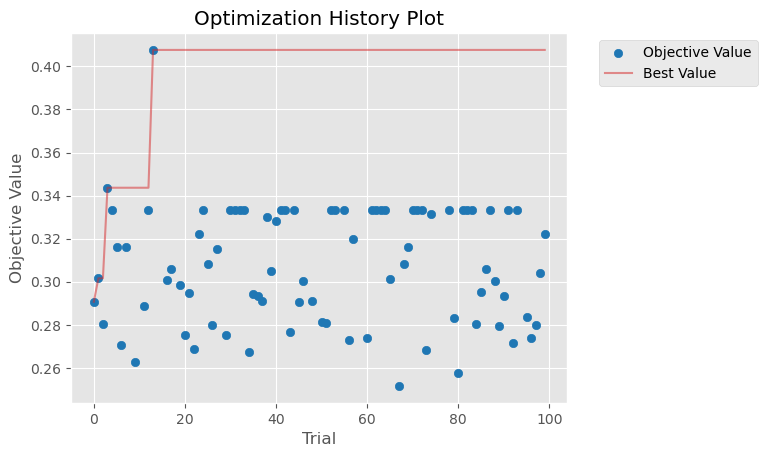

In [33]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-06-07 17:37:29,514] A new study created in memory with name: no-name-4c509bd9-ca70-4528-b595-fb63a89f5877
/tmp/ipykernel_4107673/3414932042.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


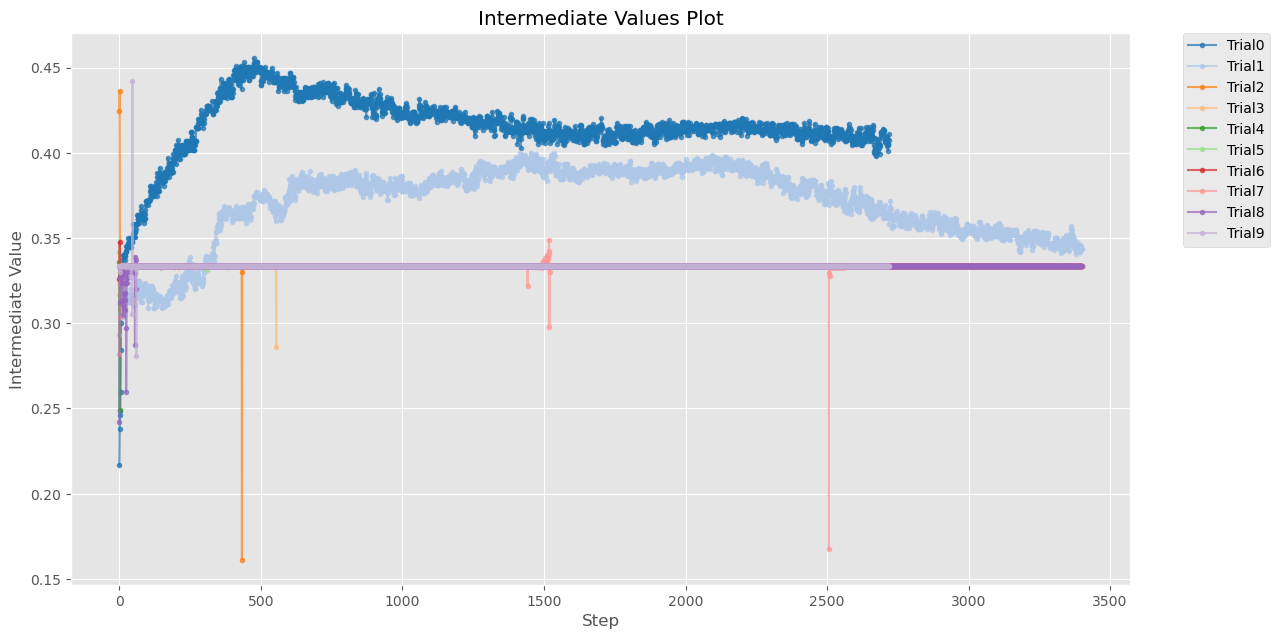

In [34]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_4107673/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


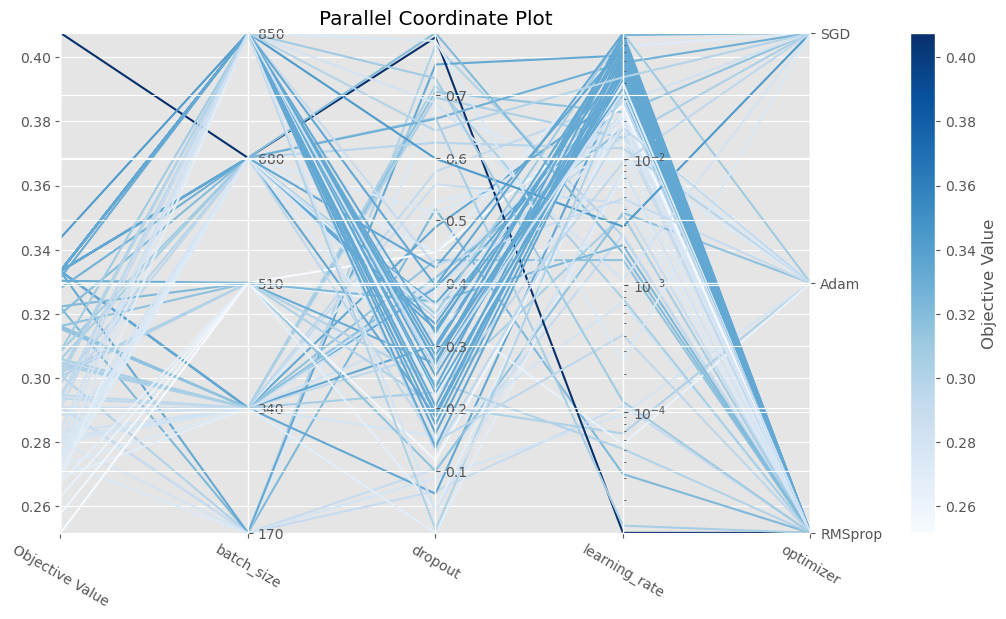

In [35]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_4107673/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-06-07 17:37:30,921] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


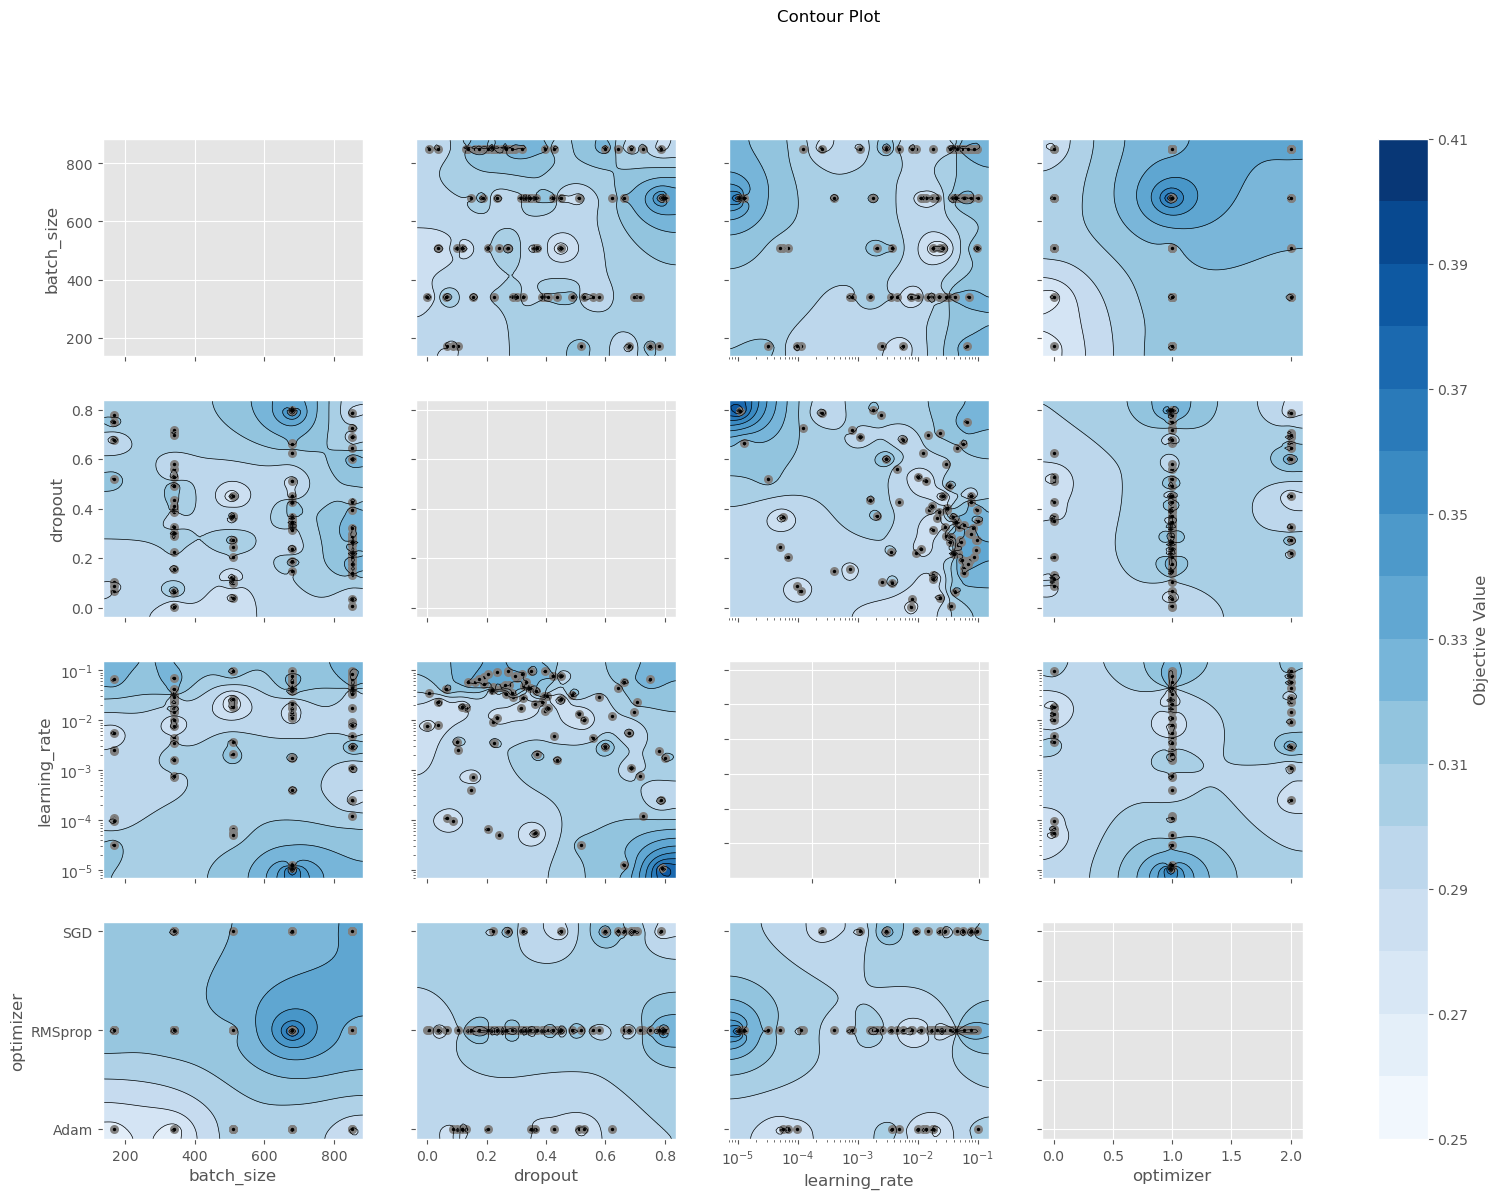

In [36]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_4107673/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

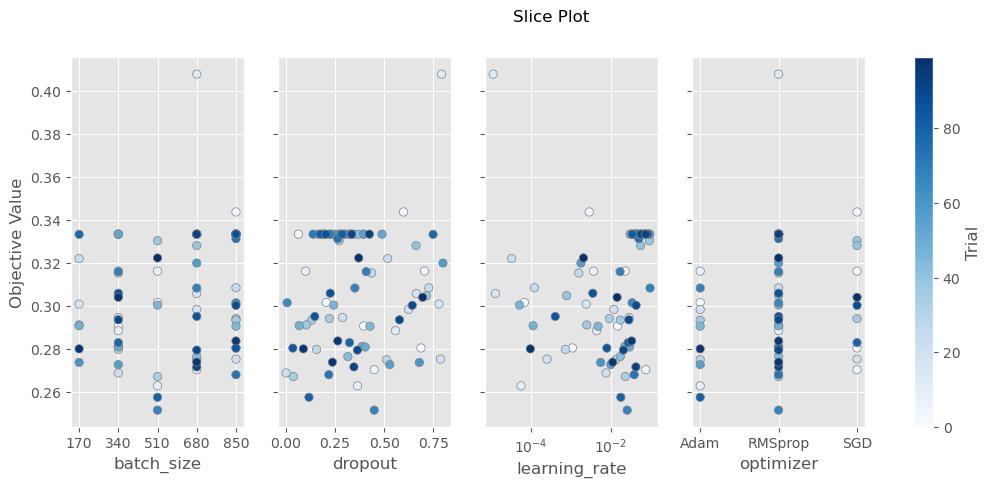

In [37]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_4107673/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

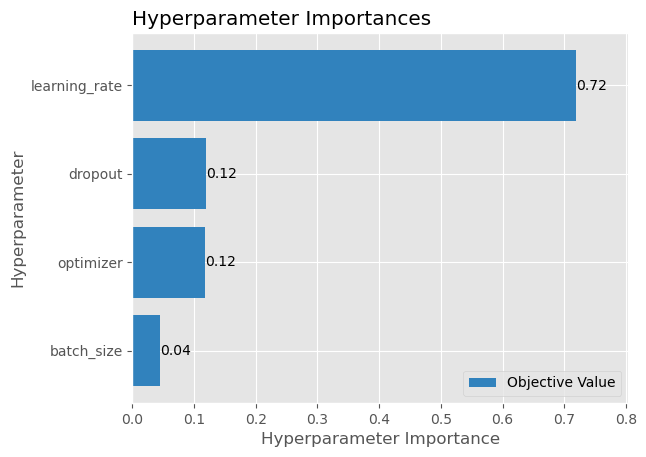

In [38]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_4107673/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

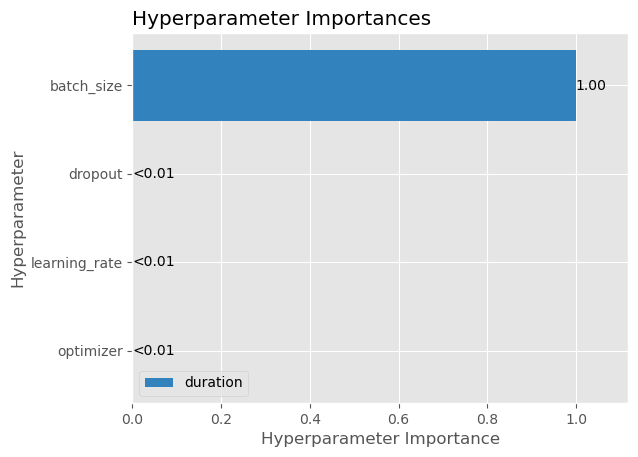

In [39]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_4107673/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

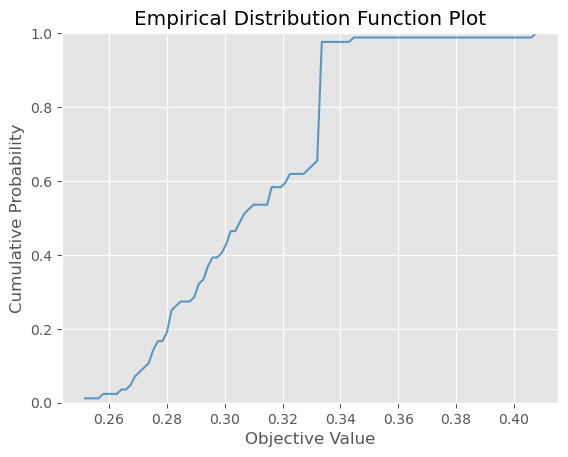

In [40]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_4107673/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-06-07 17:37:36,993] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


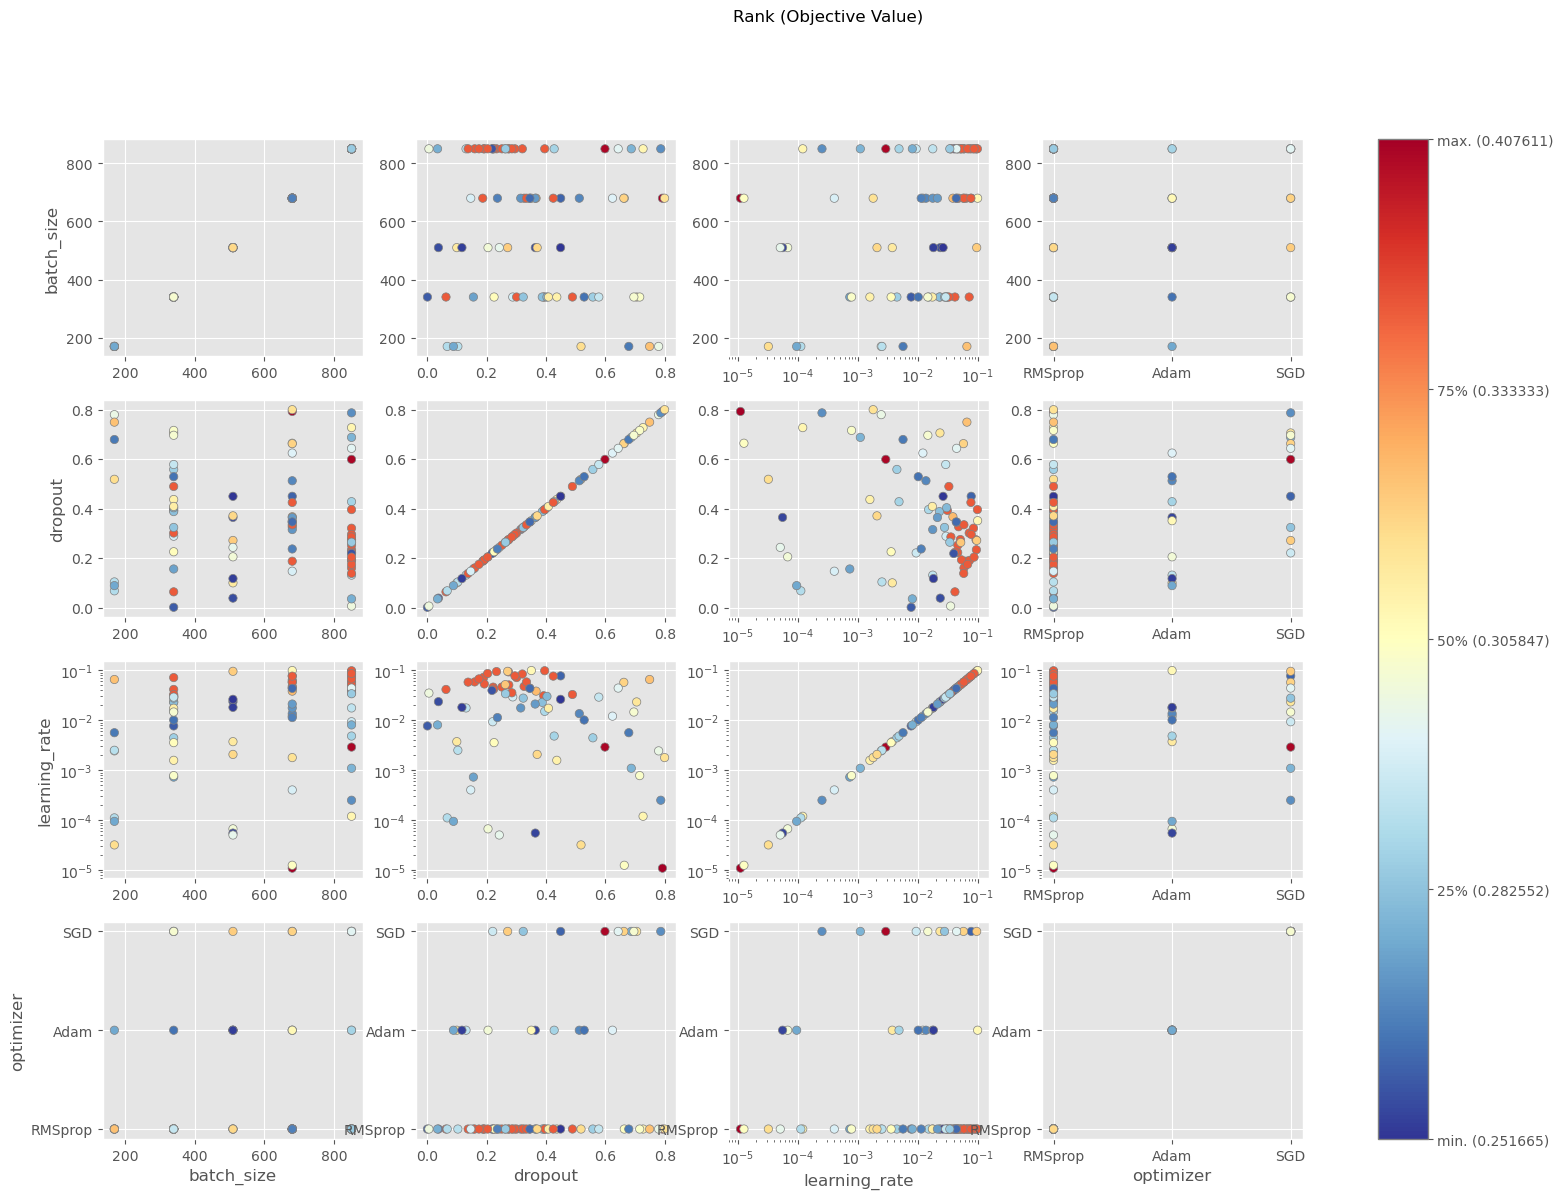

In [41]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_4107673/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


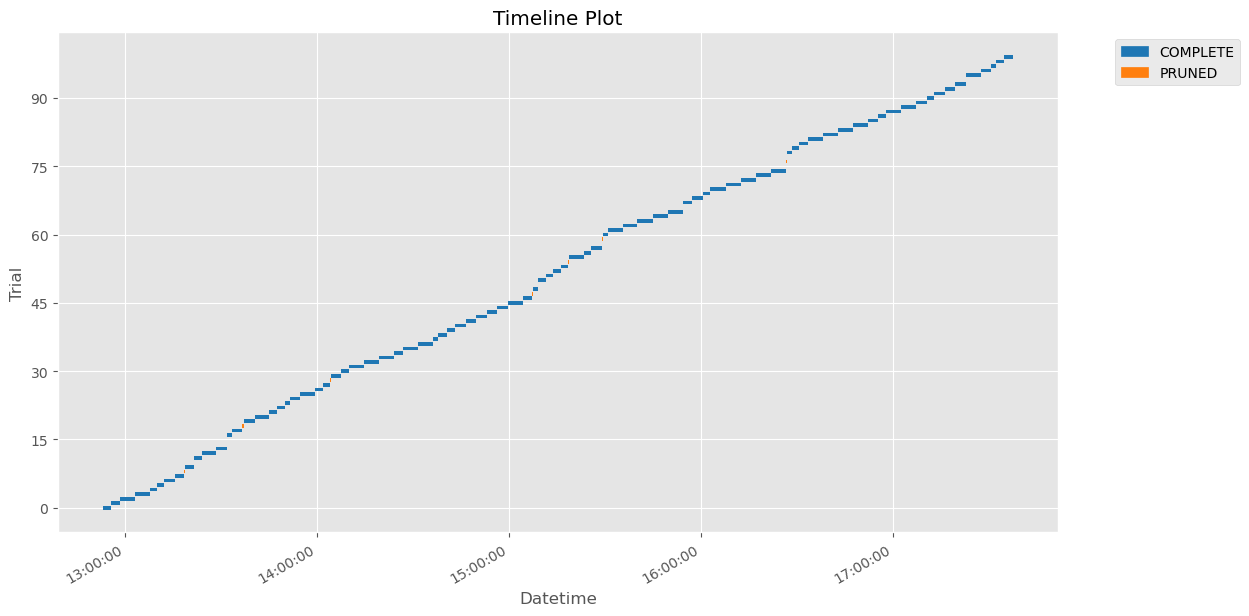

In [42]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

# 3. ratio feature set

In [43]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['ratio'][0]
baseline_val_idxs = data_split_indices['ratio'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ratio_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ratio_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ratio_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ratio_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ratio_y_list[i] for i in baseline_rest_idxs]
Y_val = [ratio_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ratio_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


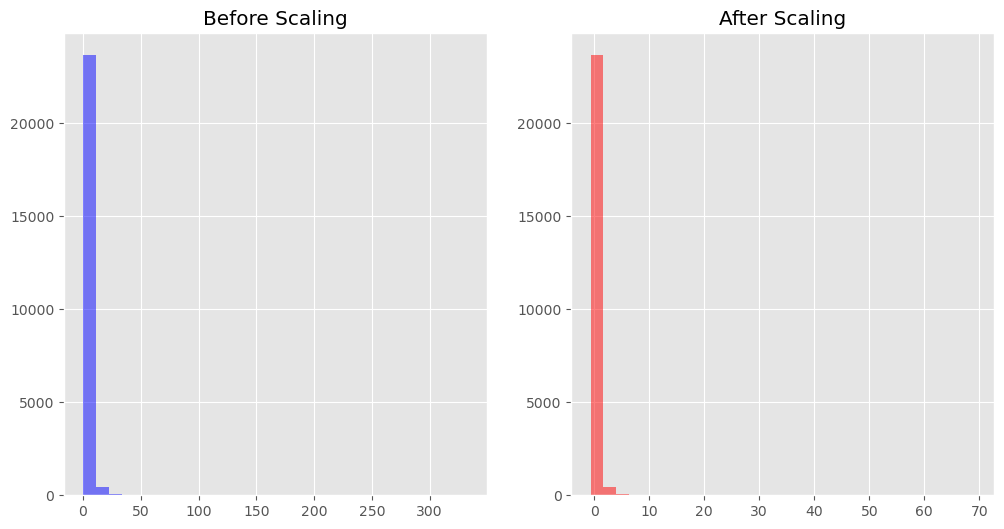

In [44]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: standard GCN

In [45]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ratio_results_stand_GCN_trials.pkl')

[I 2024-06-07 17:37:40,474] A new study created in memory with name: no-name-e0101880-ed47-4ceb-9be4-f5b971d19076
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.02586924636982292, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.4138119096122503}


[I 2024-06-07 17:39:10,052] Trial 0 finished with value: 0.3333333432674408 and parameters: {'learning_rate': 0.02586924636982292, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.4138119096122503}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.0002505343491465021, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7780009909325374}


[I 2024-06-07 17:40:40,311] Trial 1 finished with value: 0.2535049319267273 and parameters: {'learning_rate': 0.0002505343491465021, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.7780009909325374}. Best is trial 0 with value: 0.3333333432674408.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.01631782158413835, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.471446287178781}


[I 2024-06-07 17:45:24,123] Trial 2 finished with value: 0.26837971806526184 and parameters: {'learning_rate': 0.01631782158413835, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.471446287178781}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 4.457171036504286e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.41497783811213557}


[I 2024-06-07 17:50:04,034] Trial 3 finished with value: 0.3035866320133209 and parameters: {'learning_rate': 4.457171036504286e-05, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.41497783811213557}. Best is trial 0 with value: 0.3333333432674408.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.03618678060280419, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.5667887607524279}


[I 2024-06-07 17:52:55,668] Trial 4 finished with value: 0.257744163274765 and parameters: {'learning_rate': 0.03618678060280419, 'optimizer': 'SGD', 'batch_size': 510, 'dropout': 0.5667887607524279}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.0021725700542283405, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.445045587399731}


[I 2024-06-07 17:55:52,311] Trial 5 finished with value: 0.2332768440246582 and parameters: {'learning_rate': 0.0021725700542283405, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.445045587399731}. Best is trial 0 with value: 0.3333333432674408.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0018162125356420101, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.7830195165561922}


[I 2024-06-07 17:58:19,110] Trial 6 finished with value: 0.24800346791744232 and parameters: {'learning_rate': 0.0018162125356420101, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.7830195165561922}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.0780251208926463, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.7271079184915928}


[I 2024-06-07 18:02:52,571] Trial 7 finished with value: 0.2449103742837906 and parameters: {'learning_rate': 0.0780251208926463, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.7271079184915928}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.04564050567947998, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.02699682818561673}


[I 2024-06-07 18:03:00,660] Trial 8 pruned. Trial was pruned at epoch 102.


Tested parameters: {'learning_rate': 0.00019196584836096852, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.19243114131182965}


[I 2024-06-07 18:06:23,440] Trial 9 finished with value: 0.24165387451648712 and parameters: {'learning_rate': 0.00019196584836096852, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.19243114131182965}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.010658828497181187, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.24037154355485943}


[I 2024-06-07 18:07:56,293] Trial 10 finished with value: 0.2471044659614563 and parameters: {'learning_rate': 0.010658828497181187, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.24037154355485943}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.2025135405851536e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.296093431626302}


[I 2024-06-07 18:09:31,782] Trial 11 finished with value: 0.27217036485671997 and parameters: {'learning_rate': 1.2025135405851536e-05, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.296093431626302}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.9775196711239098e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.5990209163459205}


[I 2024-06-07 18:14:17,490] Trial 12 finished with value: 0.31754714250564575 and parameters: {'learning_rate': 1.9775196711239098e-05, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.5990209163459205}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.0003555879666455969, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6060121985789626}


[I 2024-06-07 18:17:36,532] Trial 13 finished with value: 0.258920818567276 and parameters: {'learning_rate': 0.0003555879666455969, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6060121985789626}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.004225357868054925, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.617686261419979}


[I 2024-06-07 18:20:01,224] Trial 14 finished with value: 0.24673396348953247 and parameters: {'learning_rate': 0.004225357868054925, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.617686261419979}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 4.6289503675707014e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.3313201834400067}


[I 2024-06-07 18:23:59,404] Trial 15 pruned. Trial was pruned at epoch 2924.


Tested parameters: {'learning_rate': 0.0006076119866363945, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5284714325852385}


[I 2024-06-07 18:25:32,856] Trial 16 finished with value: 0.2548809051513672 and parameters: {'learning_rate': 0.0006076119866363945, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5284714325852385}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.784600743049799e-05, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.6555352664234468}


[I 2024-06-07 18:30:20,338] Trial 17 finished with value: 0.2562767267227173 and parameters: {'learning_rate': 1.784600743049799e-05, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.6555352664234468}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 7.90885236345926e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.14172673509971895}


[I 2024-06-07 18:31:54,664] Trial 18 finished with value: 0.3218681514263153 and parameters: {'learning_rate': 7.90885236345926e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.14172673509971895}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 8.6005985707368e-05, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.103720279073341}


[I 2024-06-07 18:32:09,042] Trial 19 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.005031867213258824, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.12710823291727597}


[I 2024-06-07 18:33:40,158] Trial 20 finished with value: 0.25549083948135376 and parameters: {'learning_rate': 0.005031867213258824, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.12710823291727597}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 2.1854764990824245e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.3197649201513823}


[I 2024-06-07 18:35:11,077] Trial 21 finished with value: 0.30192556977272034 and parameters: {'learning_rate': 2.1854764990824245e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.3197649201513823}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 9.51925220362914e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.5129365040336107}


[I 2024-06-07 18:35:24,881] Trial 22 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 3.6477216934722034e-05, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.37774341968941116}


[I 2024-06-07 18:38:45,464] Trial 23 finished with value: 0.2983492612838745 and parameters: {'learning_rate': 3.6477216934722034e-05, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.37774341968941116}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.00012665028062038879, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.2260780316057163}


[I 2024-06-07 18:41:06,908] Trial 24 finished with value: 0.28458210825920105 and parameters: {'learning_rate': 0.00012665028062038879, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.2260780316057163}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.00046255234644237736, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.009383214424774966}


[I 2024-06-07 18:45:45,722] Trial 25 finished with value: 0.2611064910888672 and parameters: {'learning_rate': 0.00046255234644237736, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.009383214424774966}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.001059238573740512, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.6686659758776736}


[I 2024-06-07 18:47:13,750] Trial 26 finished with value: 0.28162136673927307 and parameters: {'learning_rate': 0.001059238573740512, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.6686659758776736}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 2.6752315765694913e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.3727045907113051}


[I 2024-06-07 18:48:46,613] Trial 27 finished with value: 0.2826058268547058 and parameters: {'learning_rate': 2.6752315765694913e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.3727045907113051}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 7.316192964364437e-05, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.4836627510730339}


[I 2024-06-07 18:53:26,561] Trial 28 finished with value: 0.2909433841705322 and parameters: {'learning_rate': 7.316192964364437e-05, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.4836627510730339}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.00021984405587846472, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.1788842687698664}


[I 2024-06-07 18:54:58,121] Trial 29 finished with value: 0.22504538297653198 and parameters: {'learning_rate': 0.00021984405587846472, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.1788842687698664}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.2890303893196996e-05, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.7186800364280124}


[I 2024-06-07 18:58:19,859] Trial 30 finished with value: 0.2992996275424957 and parameters: {'learning_rate': 1.2890303893196996e-05, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.7186800364280124}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 4.884306740376809e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.4013247400101109}


[I 2024-06-07 18:58:28,422] Trial 31 pruned. Trial was pruned at epoch 102.


Tested parameters: {'learning_rate': 0.00014240353995220248, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.41758970853499483}


[I 2024-06-07 18:58:36,131] Trial 32 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 5.5116722319434916e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.5484554193867619}


[I 2024-06-07 19:03:18,916] Trial 33 finished with value: 0.26415181159973145 and parameters: {'learning_rate': 5.5116722319434916e-05, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.5484554193867619}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.019644597620591734, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.45442035306281453}


[I 2024-06-07 19:03:27,328] Trial 34 pruned. Trial was pruned at epoch 103.


Tested parameters: {'learning_rate': 2.3100365823607405e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.2772665737555513}


[I 2024-06-07 19:03:35,584] Trial 35 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.0814790536737592e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.5848602705747177}


[I 2024-06-07 19:08:17,103] Trial 36 finished with value: 0.32228147983551025 and parameters: {'learning_rate': 1.0814790536737592e-05, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.5848602705747177}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.0137009289303823e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5874187202419093}


[I 2024-06-07 19:10:36,923] Trial 37 finished with value: 0.301165372133255 and parameters: {'learning_rate': 1.0137009289303823e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.5874187202419093}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 3.1332975500020054e-05, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.7014527631200947}


[I 2024-06-07 19:10:46,463] Trial 38 pruned. Trial was pruned at epoch 122.


Tested parameters: {'learning_rate': 1.6199539784789937e-05, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.4977852498900265}


[I 2024-06-07 19:13:37,309] Trial 39 finished with value: 0.3005954921245575 and parameters: {'learning_rate': 1.6199539784789937e-05, 'optimizer': 'SGD', 'batch_size': 510, 'dropout': 0.4977852498900265}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.001129169280811122, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7874300473304444}


[I 2024-06-07 19:13:50,874] Trial 40 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 3.47599118434908e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.43571267154991233}


[I 2024-06-07 19:13:58,921] Trial 41 pruned. Trial was pruned at epoch 102.


Tested parameters: {'learning_rate': 0.08243643440994641, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.5581072103053007}


[I 2024-06-07 19:18:43,756] Trial 42 finished with value: 0.2752287685871124 and parameters: {'learning_rate': 0.08243643440994641, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.5581072103053007}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.03765188805120513, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.6455487074395471}


[I 2024-06-07 19:23:26,437] Trial 43 finished with value: 0.25801172852516174 and parameters: {'learning_rate': 0.03765188805120513, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.6455487074395471}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.003544307471443279, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.34879312961266506}


[I 2024-06-07 19:28:06,005] Trial 44 finished with value: 0.27750682830810547 and parameters: {'learning_rate': 0.003544307471443279, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.34879312961266506}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.014306157534344676, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.751059087634762}


[I 2024-06-07 19:30:59,988] Trial 45 finished with value: 0.266693115234375 and parameters: {'learning_rate': 0.014306157534344676, 'optimizer': 'SGD', 'batch_size': 510, 'dropout': 0.751059087634762}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.00030821133416594873, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.07458427965602993}


[I 2024-06-07 19:33:23,410] Trial 46 finished with value: 0.2514273226261139 and parameters: {'learning_rate': 0.00030821133416594873, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.07458427965602993}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 6.749441079483832e-05, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.47005467706725196}


[I 2024-06-07 19:38:06,327] Trial 47 finished with value: 0.23935501277446747 and parameters: {'learning_rate': 6.749441079483832e-05, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.47005467706725196}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.5102620448724458e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.6142080720939227}


[I 2024-06-07 19:39:41,056] Trial 48 finished with value: 0.28169509768486023 and parameters: {'learning_rate': 1.5102620448724458e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.6142080720939227}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.00014272693311458904, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.2545877733555359}


[I 2024-06-07 19:44:32,016] Trial 49 finished with value: 0.27368173003196716 and parameters: {'learning_rate': 0.00014272693311458904, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.2545877733555359}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.0006667426683758201, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.19634517930743034}


[I 2024-06-07 19:47:48,301] Trial 50 finished with value: 0.24474389851093292 and parameters: {'learning_rate': 0.0006667426683758201, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.19634517930743034}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 2.0925257225598454e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.29856013493388506}


[I 2024-06-07 19:49:24,858] Trial 51 finished with value: 0.2988390624523163 and parameters: {'learning_rate': 2.0925257225598454e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.29856013493388506}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.0273578428668981e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.32098278959494864}


[I 2024-06-07 19:49:38,759] Trial 52 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.078626988296197e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.13613978038265628}


[I 2024-06-07 19:51:11,503] Trial 53 finished with value: 0.3126048445701599 and parameters: {'learning_rate': 2.078626988296197e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.13613978038265628}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 4.072817706878676e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.1342572322222356}


[I 2024-06-07 19:51:25,952] Trial 54 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.58351730136163e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.0712799273113343}


[I 2024-06-07 19:51:39,503] Trial 55 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.8081642127742567e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.16661421206133428}


[I 2024-06-07 19:51:53,113] Trial 56 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00010792259361812278, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.529547633047929}


[I 2024-06-07 19:52:10,731] Trial 57 pruned. Trial was pruned at epoch 120.


Tested parameters: {'learning_rate': 0.007189580729190218, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.3665424768440147}


[I 2024-06-07 19:56:54,141] Trial 58 finished with value: 0.23770083487033844 and parameters: {'learning_rate': 0.007189580729190218, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.3665424768440147}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 6.042835128159205e-05, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.574863903591727}


[I 2024-06-07 20:00:14,414] Trial 59 finished with value: 0.2875836491584778 and parameters: {'learning_rate': 6.042835128159205e-05, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.574863903591727}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 2.0687616438838024e-05, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.05146106504763105}


[I 2024-06-07 20:02:37,490] Trial 60 finished with value: 0.2870711088180542 and parameters: {'learning_rate': 2.0687616438838024e-05, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.05146106504763105}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 2.5507097217694725e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.14879647922686134}


[I 2024-06-07 20:04:13,555] Trial 61 finished with value: 0.25976136326789856 and parameters: {'learning_rate': 2.5507097217694725e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.14879647922686134}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 4.610648681539459e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.2174453767277581}


[I 2024-06-07 20:05:45,991] Trial 62 finished with value: 0.2568996250629425 and parameters: {'learning_rate': 4.610648681539459e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.2174453767277581}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.2633124812780536e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.41138203425168085}


[I 2024-06-07 20:05:59,658] Trial 63 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.8912955002577657e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.639488599694242}


[I 2024-06-07 20:07:35,405] Trial 64 finished with value: 0.305777907371521 and parameters: {'learning_rate': 1.8912955002577657e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.639488599694242}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 3.575254696086834e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.6863213833583753}


[I 2024-06-07 20:09:08,799] Trial 65 finished with value: 0.283561110496521 and parameters: {'learning_rate': 3.575254696086834e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.6863213833583753}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 8.600171814572871e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.6591239378316622}


[I 2024-06-07 20:10:44,309] Trial 66 finished with value: 0.24851056933403015 and parameters: {'learning_rate': 8.600171814572871e-05, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.6591239378316622}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 0.0019157368695634385, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.5952728164976957}


[I 2024-06-07 20:13:35,367] Trial 67 finished with value: 0.26996058225631714 and parameters: {'learning_rate': 0.0019157368695634385, 'optimizer': 'SGD', 'batch_size': 510, 'dropout': 0.5952728164976957}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.7671776482978126e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.5189812283691839}


[I 2024-06-07 20:13:43,634] Trial 68 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00016615801466588221, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.11666116036733037}


[I 2024-06-07 20:15:20,735] Trial 69 finished with value: 0.2548368573188782 and parameters: {'learning_rate': 0.00016615801466588221, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.11666116036733037}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.0046620986472232e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.635291797857886}


[I 2024-06-07 20:19:55,824] Trial 70 finished with value: 0.27086299657821655 and parameters: {'learning_rate': 1.0046620986472232e-05, 'optimizer': 'SGD', 'batch_size': 850, 'dropout': 0.635291797857886}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 2.185684927132487e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.2598670192551312}


[I 2024-06-07 20:20:09,736] Trial 71 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.4169034949457985e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.43647686133140273}


[I 2024-06-07 20:21:44,752] Trial 72 finished with value: 0.3058534264564514 and parameters: {'learning_rate': 1.4169034949457985e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.43647686133140273}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.3616524291278962e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.38780663259120884}


[I 2024-06-07 20:23:19,450] Trial 73 finished with value: 0.3094078302383423 and parameters: {'learning_rate': 1.3616524291278962e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.38780663259120884}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.3238482673767778e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.4462899088005393}


[I 2024-06-07 20:23:33,205] Trial 74 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.05150186730603635, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.5450905221595672}


[I 2024-06-07 20:25:06,280] Trial 75 finished with value: 0.24708281457424164 and parameters: {'learning_rate': 0.05150186730603635, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.5450905221595672}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.802535192127704e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7515344230435466}


[I 2024-06-07 20:26:39,498] Trial 76 finished with value: 0.3301761746406555 and parameters: {'learning_rate': 1.802535192127704e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.7515344230435466}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.3772127862785409e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.38668760483882675}


[I 2024-06-07 20:26:53,060] Trial 77 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.02450301827618626, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.47753767023104327}


[I 2024-06-07 20:28:25,282] Trial 78 finished with value: 0.2235482931137085 and parameters: {'learning_rate': 0.02450301827618626, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.47753767023104327}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 2.653869249206342e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7195425098614334}


[I 2024-06-07 20:29:59,183] Trial 79 finished with value: 0.30889004468917847 and parameters: {'learning_rate': 2.653869249206342e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.7195425098614334}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 2.878867750345652e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7463481980003835}


[I 2024-06-07 20:31:31,097] Trial 80 finished with value: 0.27804142236709595 and parameters: {'learning_rate': 2.878867750345652e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.7463481980003835}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.673407759560297e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7702972954020821}


[I 2024-06-07 20:33:03,378] Trial 81 finished with value: 0.3332616090774536 and parameters: {'learning_rate': 1.673407759560297e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.7702972954020821}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 3.2243494842826576e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.75076372884624}


[I 2024-06-07 20:34:34,665] Trial 82 finished with value: 0.26317477226257324 and parameters: {'learning_rate': 3.2243494842826576e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.75076372884624}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 4.2578995154593514e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7925116526784439}


[I 2024-06-07 20:34:48,428] Trial 83 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.473008573225568e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.770371648589083}


[I 2024-06-07 20:36:21,508] Trial 84 finished with value: 0.3332642912864685 and parameters: {'learning_rate': 2.473008573225568e-05, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.770371648589083}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.8401797889912664e-05, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.7671957966952109}


[I 2024-06-07 20:38:43,449] Trial 85 finished with value: 0.29850271344184875 and parameters: {'learning_rate': 1.8401797889912664e-05, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.7671957966952109}. Best is trial 0 with value: 0.3333333432674408.


Tested parameters: {'learning_rate': 1.1205266091472155e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6935292250727657}


[I 2024-06-07 20:42:01,183] Trial 86 finished with value: 0.3460588753223419 and parameters: {'learning_rate': 1.1205266091472155e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6935292250727657}. Best is trial 86 with value: 0.3460588753223419.


Tested parameters: {'learning_rate': 1.129090828916563e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.701103258323578}


[I 2024-06-07 20:45:16,486] Trial 87 finished with value: 0.29747653007507324 and parameters: {'learning_rate': 1.129090828916563e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.701103258323578}. Best is trial 86 with value: 0.3460588753223419.


Tested parameters: {'learning_rate': 2.3382512295999063e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.7424648279457697}


[I 2024-06-07 20:45:25,672] Trial 88 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.6736085918718216e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6775796645724176}


[I 2024-06-07 20:48:41,074] Trial 89 finished with value: 0.2700671851634979 and parameters: {'learning_rate': 1.6736085918718216e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6775796645724176}. Best is trial 86 with value: 0.3460588753223419.


Tested parameters: {'learning_rate': 6.039904315273398e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7692435568486725}


[I 2024-06-07 20:52:02,619] Trial 90 finished with value: 0.2898268699645996 and parameters: {'learning_rate': 6.039904315273398e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7692435568486725}. Best is trial 86 with value: 0.3460588753223419.


Tested parameters: {'learning_rate': 1.2056242963726206e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7012443733904739}


[I 2024-06-07 20:55:20,163] Trial 91 finished with value: 0.27877920866012573 and parameters: {'learning_rate': 1.2056242963726206e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7012443733904739}. Best is trial 86 with value: 0.3460588753223419.


Tested parameters: {'learning_rate': 1.4994263822189542e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7965864854629097}


[I 2024-06-07 20:55:34,271] Trial 92 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 3.576139048068869e-05, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.726441468832129}


[I 2024-06-07 20:57:11,440] Trial 93 finished with value: 0.2648230195045471 and parameters: {'learning_rate': 3.576139048068869e-05, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.726441468832129}. Best is trial 86 with value: 0.3460588753223419.


Tested parameters: {'learning_rate': 1.0144383026164068e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.09679521551913814}


[I 2024-06-07 20:57:25,202] Trial 94 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0031152033864848, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.765503499420904}


[I 2024-06-07 21:00:47,160] Trial 95 finished with value: 0.23518535494804382 and parameters: {'learning_rate': 0.0031152033864848, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.765503499420904}. Best is trial 86 with value: 0.3460588753223419.


Tested parameters: {'learning_rate': 0.0013467837395987141, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.773985312467675}


[I 2024-06-07 21:01:00,184] Trial 96 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.016191257916882e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.6168982854501407}


[I 2024-06-07 21:01:10,042] Trial 97 pruned. Trial was pruned at epoch 116.


Tested parameters: {'learning_rate': 0.007626097897855576, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.6895217350699142}


[I 2024-06-07 21:02:48,356] Trial 98 finished with value: 0.2680153250694275 and parameters: {'learning_rate': 0.007626097897855576, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.6895217350699142}. Best is trial 86 with value: 0.3460588753223419.


Tested parameters: {'learning_rate': 2.482180743376135e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.7282473087217799}


[I 2024-06-07 21:05:09,178] Trial 99 finished with value: 0.31827136874198914 and parameters: {'learning_rate': 2.482180743376135e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.7282473087217799}. Best is trial 86 with value: 0.3460588753223419.


Best trial:
  Value: 0.3460588753223419
  Params: 
    learning_rate: 1.1205266091472155e-05
    optimizer: RMSprop
    batch_size: 680
    dropout: 0.6935292250727657


In [46]:
df_trials = pd.read_pickle('ratio_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
86      86  0.346059 2024-06-07 20:38:43.450343 2024-06-07 20:42:01.180606   
0        0  0.333333 2024-06-07 17:37:40.477929 2024-06-07 17:39:10.051067   
84      84  0.333264 2024-06-07 20:34:48.428870 2024-06-07 20:36:21.507320   
81      81  0.333262 2024-06-07 20:31:31.099132 2024-06-07 20:33:03.377173   
76      76  0.330176 2024-06-07 20:25:06.281035 2024-06-07 20:26:39.497371   
36      36  0.322281 2024-06-07 19:03:35.585725 2024-06-07 19:08:17.100763   
18      18  0.321868 2024-06-07 18:30:20.339992 2024-06-07 18:31:54.663960   
99      99  0.318271 2024-06-07 21:02:48.357586 2024-06-07 21:05:09.176198   
12      12  0.317547 2024-06-07 18:09:31.783184 2024-06-07 18:14:17.487785   
53      53  0.312605 2024-06-07 19:49:38.761099 2024-06-07 19:51:11.502666   

                 duration  params_batch_size  params_dropout  \
86 0 days 00:03:17.730263                680        0.693529   
0  0 days 00:01:29.573138                170        0.413812   
84 0 days 00:01:33.078450                170        0.770372   
81 0 days 00:01:32.278041                170        0.770297   
76 0 days 00:01:33.216336                170        0.751534   
36 0 days 00:04:41.515038                850        0.584860   
18 0 days 00:01:34.323968                170        0.141727   
99 0 days 00:02:20.818612                340        0.728247   
12 0 days 00:04:45.704601                850        0.599021   
53 0 days 00:01:32.741567                170        0.136140   

    params_learning_rate params_optimizer     state  
86              0.000011          RMSprop  COMPLETE  
0               0.025869          RMSprop  COMPLETE  
84              0.000025              SGD  COMPLETE  
81              0.000017              SGD  COMPLETE  
76              0.000018              SGD  COMPLETE  
36              0.000011              SGD  COMPLETE  
18              0.000079              SGD  COMPLETE  
99              0.000025          RMSprop  COMPLETE  
12              0.000020              SGD  COMPLETE  
53              0.000021              SGD  COMPLETE

#### Visualizations

/tmp/ipykernel_4107673/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

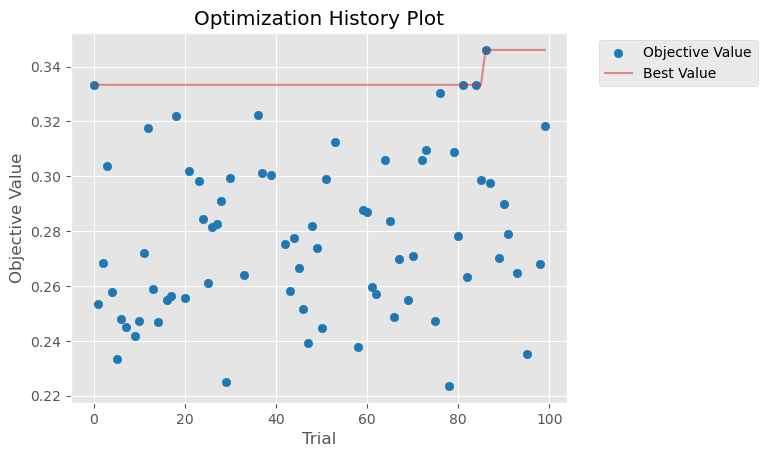

In [47]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-06-07 21:05:09,588] A new study created in memory with name: no-name-0017d96f-30ec-4fbd-b2f9-2b91cb36cf4a
/tmp/ipykernel_4107673/3414932042.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


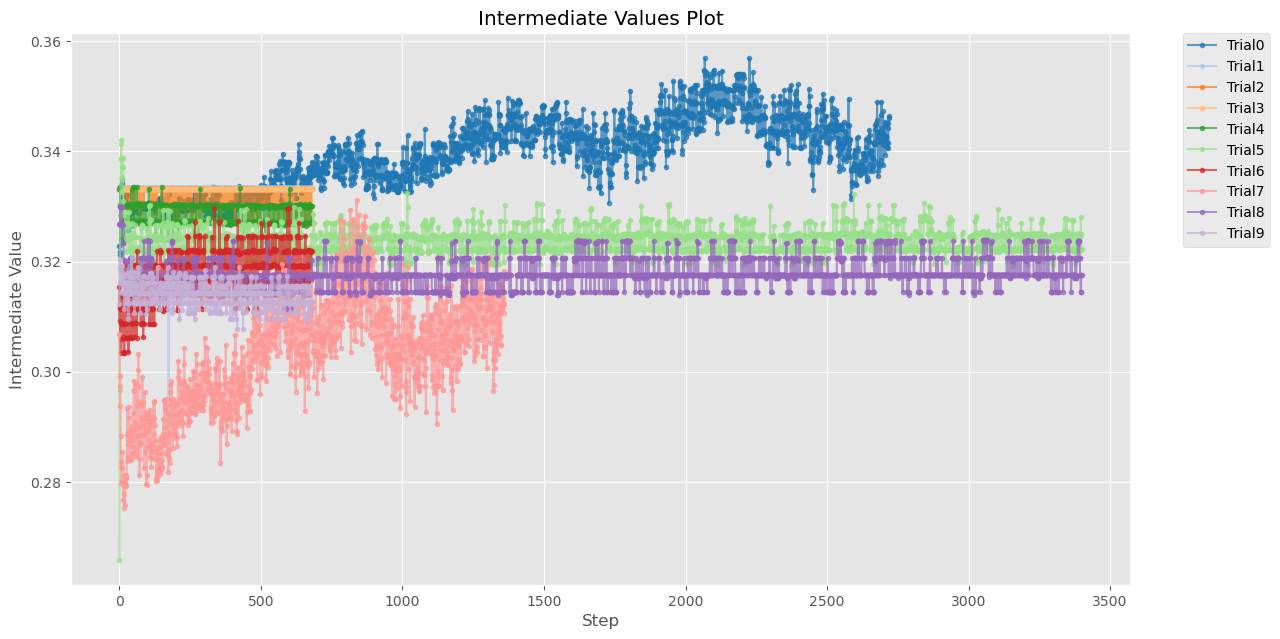

In [48]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_4107673/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


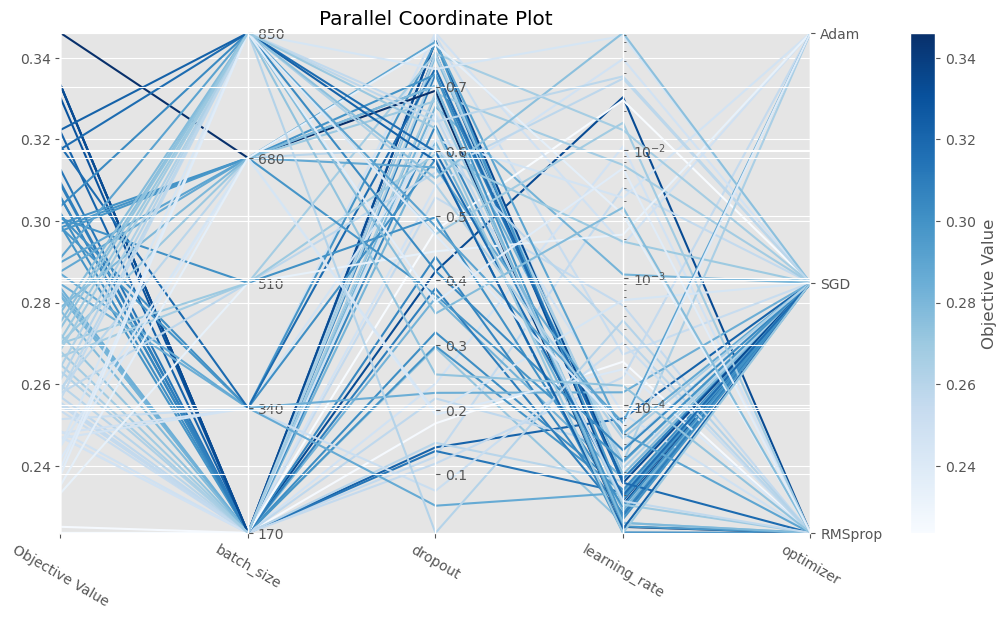

In [49]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_4107673/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-06-07 21:05:11,156] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


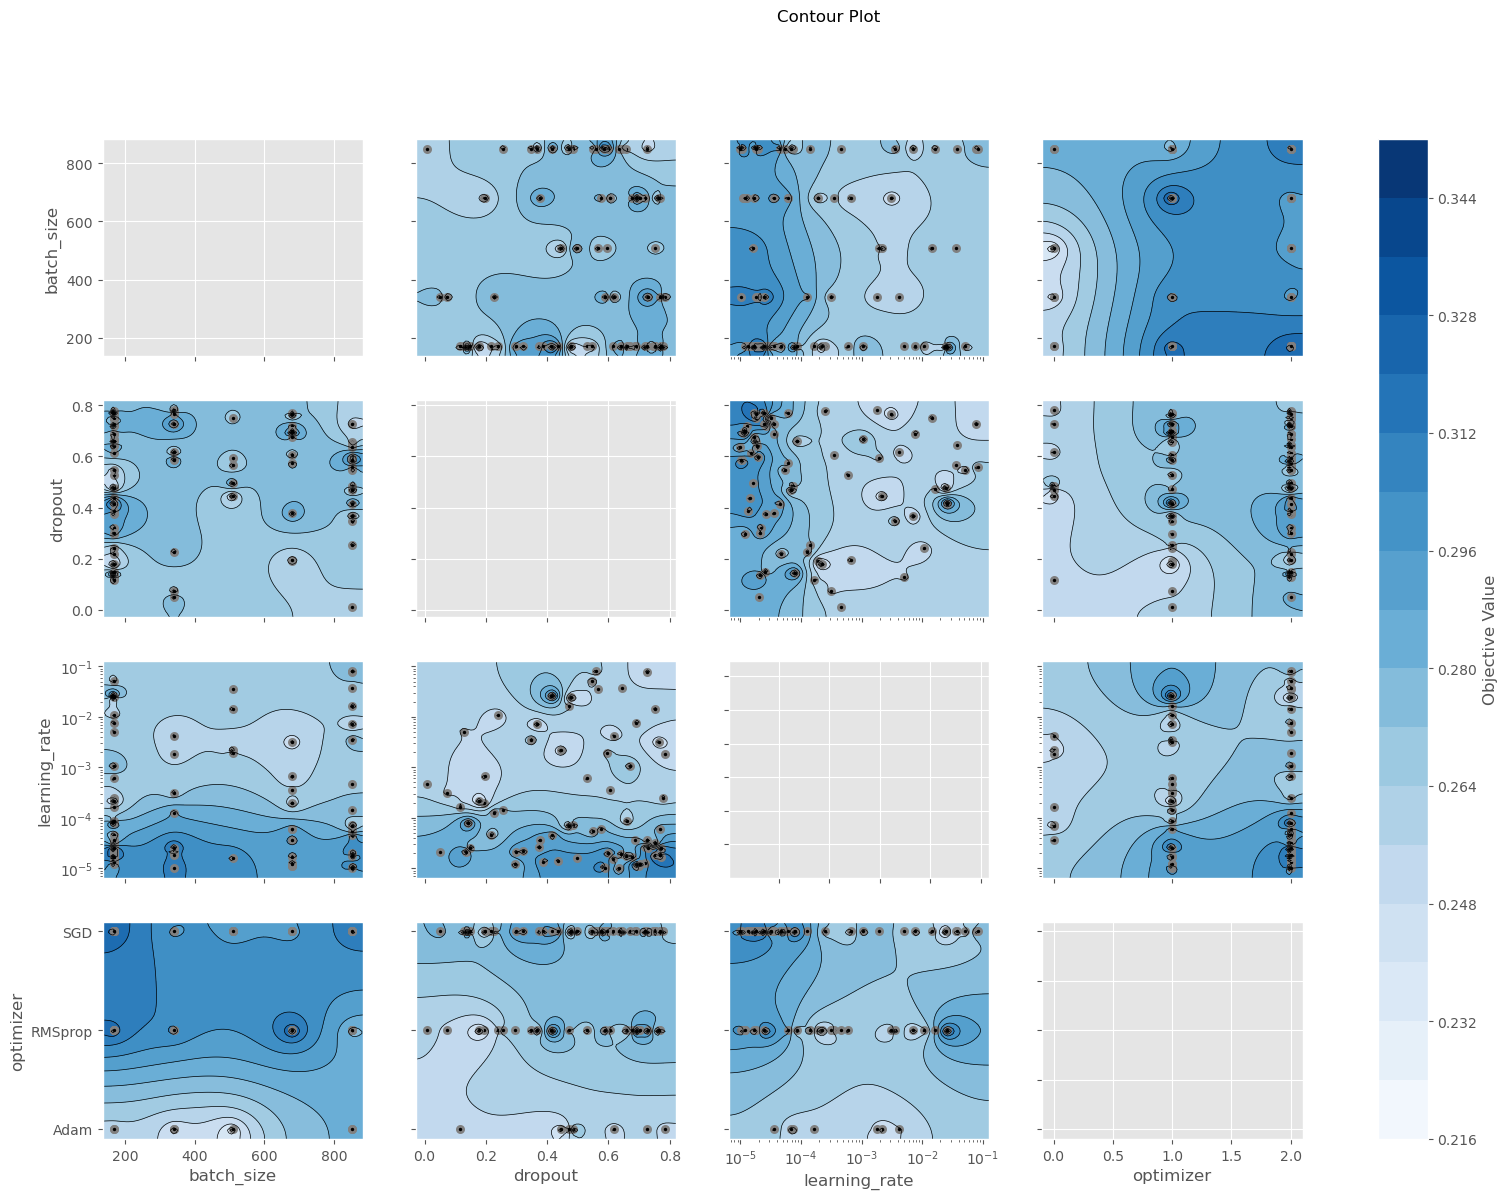

In [50]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_4107673/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

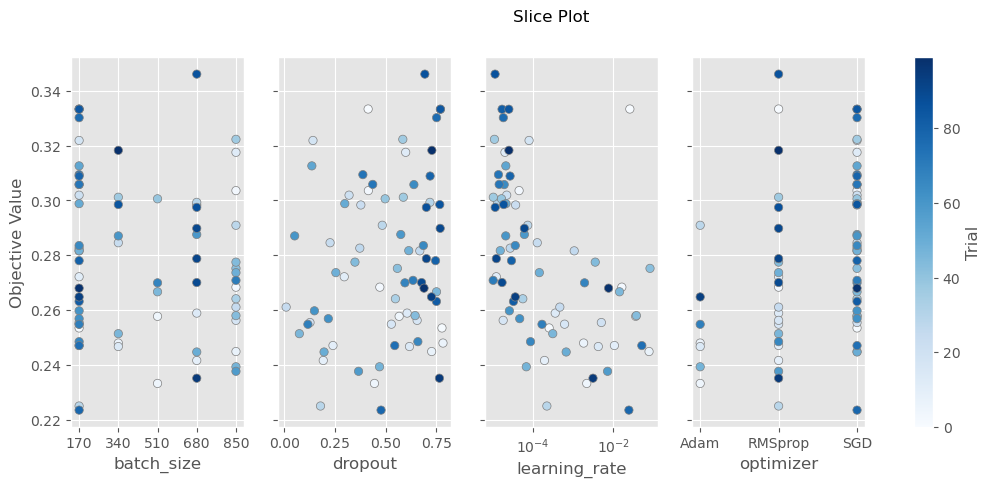

In [51]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_4107673/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

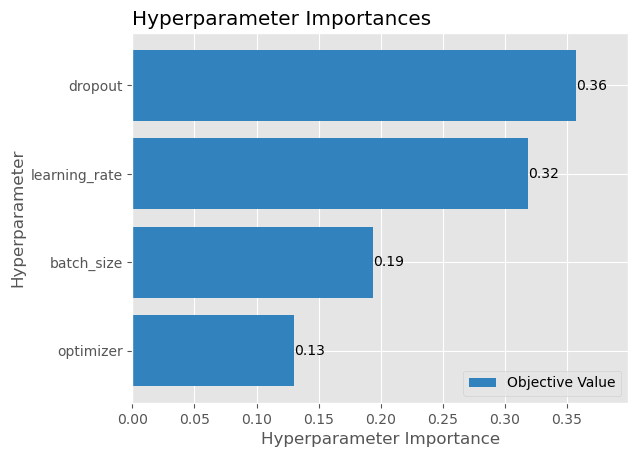

In [52]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_4107673/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

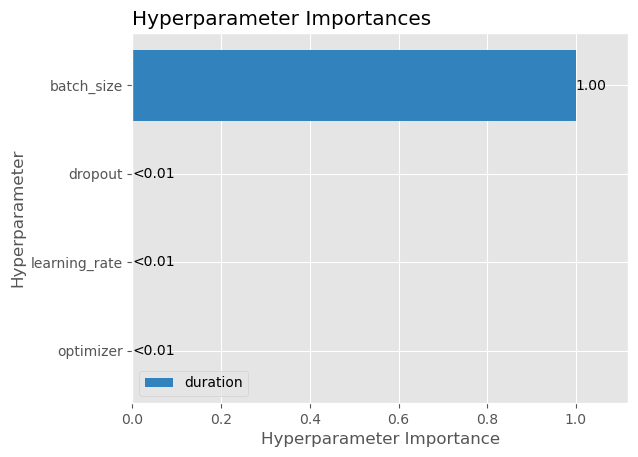

In [53]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_4107673/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

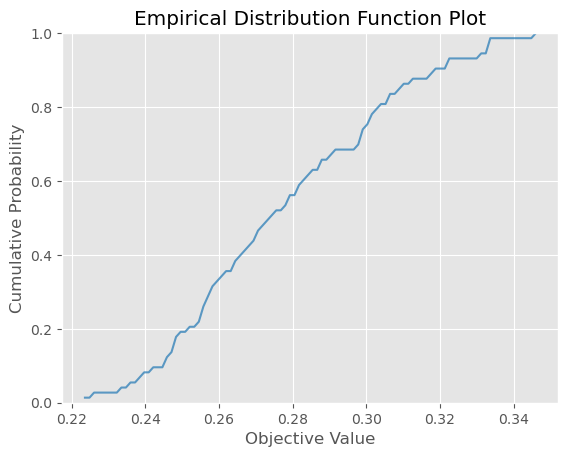

In [54]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_4107673/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-06-07 21:05:17,043] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


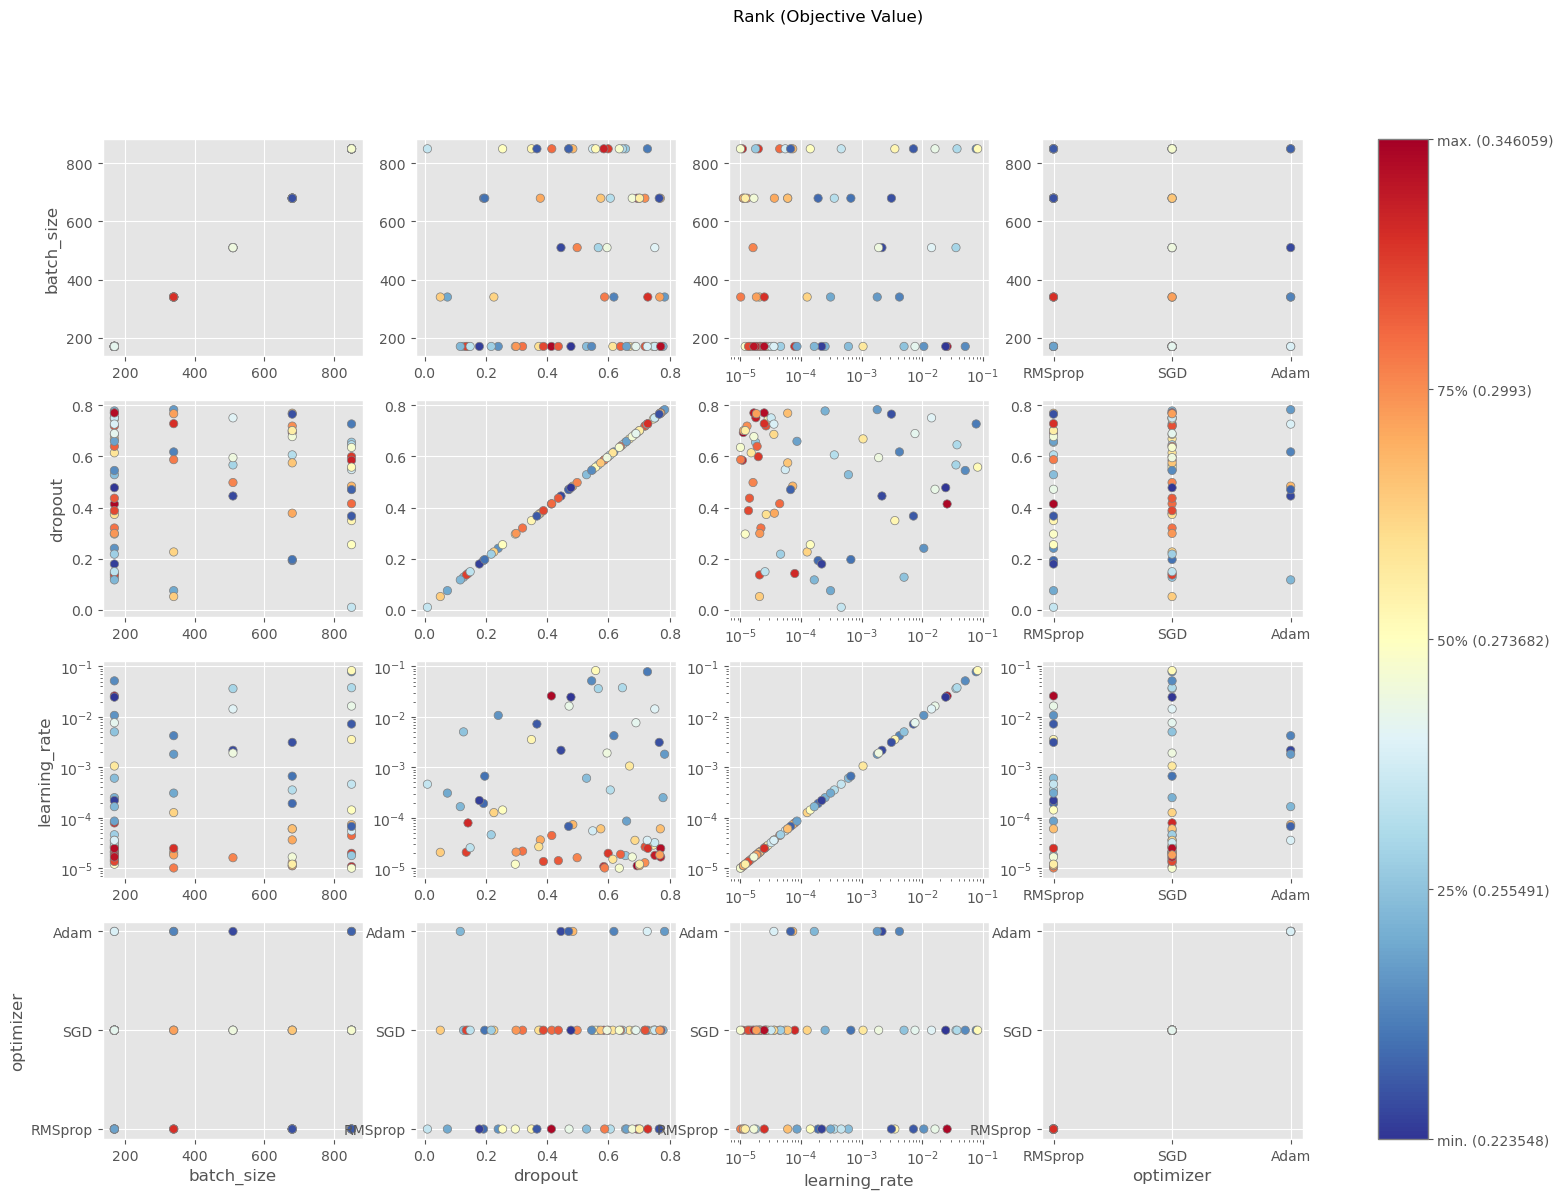

In [55]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_4107673/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


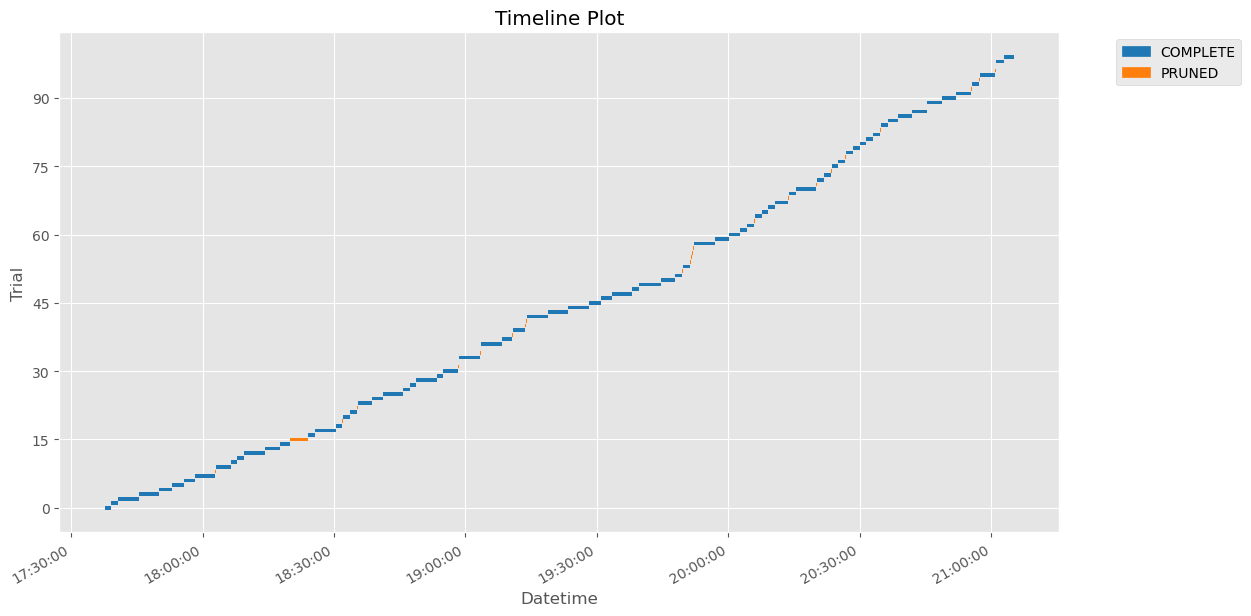

In [56]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)